# Dataset to Sequence

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
import tensorflow as tf

# Check if TensorFlow detects GPU
print("Is TensorFlow using GPU?", tf.config.list_physical_devices('GPU'))


Is TensorFlow using GPU? [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
df = pd.read_csv('/content/drive/MyDrive/filtered.csv')

In [4]:
df.head()

,Unnamed: 0,Sport_-1,drug_1896,equity_1896,drug_1900,equity_1900,drug_1904,equity_1904,drug_1906,equity_1906,...,CV_1980,CV_1984,CV_1988,CV_1992,CV_1996,CV_2000,CV_2004,CV_2008,CV_2012,CV_2016
0,0,Alpine Skiing,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.941454,0.810152,0.975410,1.038671,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,Alpinism,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2,Archery,0.0,NaN,NaN,0.0,NaN,0.228571,NaN,NaN,...,0.518674,0.486000,0.736622,0.877037,0.872777,0.840279,0.893923,0.819216,0.751548,0.849326
3,3,Art Competitions,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,4,Athletics,0.0,0.0,NaN,0.0,NaN,0.000000,NaN,0.0,...,1.012697,1.053289,1.032190,0.986700,1.016212,0.982383,0.984688,1.058562,0.964608,0.974802


In [5]:
data_dict = {}

for sport in df['Sport_-1'].unique():
    sport_data = df[df['Sport_-1'] == sport]
    sport_dict = {}

    for variable in ['drug', 'equity', 'popularity', 'normalized_country', 'CV']:
        # Filter the columns that belong to the current variable
        variable_cols = [col for col in df.columns if col.startswith(variable)]

        # Create a DataFrame with years and the corresponding values for this variable
        year_variable_df = sport_data[variable_cols].melt(var_name='Year_Var', value_name=variable)

        # Extract the year from the column names
        year_variable_df['Year'] = year_variable_df['Year_Var'].str.extract('(\d{4})').astype(int)
        year_variable_df = year_variable_df[['Year', variable]].dropna()

        # Add this DataFrame to the sport's dictionary
        sport_dict[variable] = year_variable_df.reset_index(drop=True)

    # Add the sport's dictionary to the main dictionary
    data_dict[sport] = sport_dict

DIctionary is in the structure of,

    "Alpine Skiing": {
        "drug":       # DataFrame for the 'drug' variable
                    Year    drug
                    1896    0.0
                    1900    NaN
                    1904    NaN
                    ...
        "equity":    # DataFrame for the 'equity' variable
                    Year    equity
                    1896    NaN
                    1900    NaN
                    1904    NaN
                    ...
        "popularity": # DataFrame for the 'popularity' variable
                    Year    popularity
                    1896    NaN
                    1900    NaN
                    1904    NaN
                    ...
        "normalized_country": # DataFrame for 'normalized_country' variable
                    Year    normalized_country
                    1896    NaN
                    1900    NaN
                    1904    NaN
                    ...
        "CV":        # DataFrame for 'CV' variable
                    Year    CV
                    1980    0.94154
                    1984    0.810152
                    1988    0.975410
                    ...
    },


    # Similar structure for other sports



In [6]:
df_Athletes_CV = data_dict['Athletics']['CV']
df_Athletes_CV.head()

,Year,CV
0,1896,1.001050
1,1900,0.975667
2,1904,0.978102
3,1906,0.892952
4,1908,1.032252


# Processing Data

In [ ]:
print("Number of missing values in 'CV':", df_Athletes_CV['CV'].isnull().sum())


Number of missing values in 'CV': 0


In [ ]:
df_Athletes_CV['CV'] = df_Athletes_CV['CV'].interpolate(method='linear')


In [ ]:
df_Athletes_CV = df_Athletes_CV.sort_values('Year').reset_index(drop=True)


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
df_Athletes_CV['CV_scaled'] = scaler.fit_transform(df_Athletes_CV['CV'].values.reshape(-1, 1))


In [ ]:
#creating lstm input
def create_sequences(data, window_size):
    X = []
    y = []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)


In [ ]:
window_size = 3  # You can adjust this value
data = df_Athletes_CV['CV_scaled'].values
X, y = create_sequences(data, window_size)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False)


In [ ]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


# define visualization function

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

def plot_training_history(history, metrics=('mse', 'r2_keras')):
    """
    Plot training and validation metrics over epochs.

    Args:
        history: Keras History object after model training.
        metrics: Tuple of metrics to plot. Default is ('mse', 'r2_keras').
    """
    plt.figure(figsize=(12, 4))

    # Plot each metric
    for i, metric in enumerate(metrics):
        plt.subplot(1, len(metrics), i + 1)
        plt.plot(history.history[metric], label=f'Training {metric.upper()}')
        plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric.upper()}')
        plt.title(f'{metric.upper()} Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel(metric.upper())
        plt.legend()

    plt.tight_layout()
    plt.show()

def evaluate_model(model, X_test, y_test):
    """
    Evaluate the model on test data and compute MSE and R².

    Args:
        model: Trained model to evaluate.
        X_test: Test input data.
        y_test: Test target data.

    Returns:
        test_mse: Mean Squared Error on the test set.
        test_r2: R² score on the test set.
    """
    # Make predictions
    y_pred = model.predict(X_test)

    # Reshape y_test if necessary
    if y_test.ndim > 1:
        y_test = y_test.reshape(-1)

    # Compute metrics
    test_mse = mean_squared_error(y_test, y_pred)
    test_r2 = r2_score(y_test, y_pred)

    print(f"Test MSE: {test_mse}")
    print(f"Test R²: {test_r2}")

    return test_mse, test_r2

def plot_predictions(model, data, window_size, scaler, years, target_column='CV_scaled', title='Actual vs Predicted CV Values Over Years'):
    """
    Plot actual vs predicted values for a given model.

    Args:
        model: Trained model for prediction.
        data: DataFrame or array containing the input data.
        window_size: Size of the sequence window used during training.
        scaler: Scaler object used for scaling the data.
        years: Array of years corresponding to the data.
        target_column: Column name of the scaled target variable in `data`.
        title: Title for the plot.
    """
    # Extract the target column as a NumPy array
    data_values = data[target_column].values

    # Create sequences
    X_all, y_all = create_sequences(data_values, window_size)

    # Reshape for LSTM input
    X_all = X_all.reshape((X_all.shape[0], X_all.shape[1], 1))

    # Make predictions
    y_pred_scaled = model.predict(X_all)

    # Inverse transform predictions and actual values
    y_pred = scaler.inverse_transform(y_pred_scaled)
    y_actual = scaler.inverse_transform(y_all.reshape(-1, 1))

    # Adjust years to match the prediction length
    adjusted_years = years[window_size:]

    # Plot actual vs predicted values
    plt.figure(figsize=(12, 6))
    plt.plot(adjusted_years, y_actual, label='Actual', marker='o')
    plt.plot(adjusted_years, y_pred, label='Predicted', marker='x')
    plt.xlabel('Year')
    plt.ylabel('CV')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


# Attempt 1: vanilla lstm

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from sklearn.metrics import r2_score, mean_squared_error

In [ ]:
def r2_keras(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    r2 = 1 - SS_res / (SS_tot + K.epsilon())
    return r2

In [ ]:
model = Sequential()
model.add(LSTM(units=64, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dense(units=1))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse', r2_keras])

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=15,         # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the weights from the epoch with the best value of the monitored quantity
)

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=500,                # Maximum number of epochs
    batch_size=1,              # You can adjust this based on your dataset size
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1                  # Set to 1 to print progress for each epoch
)

Epoch 1/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.2653 - mse: 0.2653 - r2_keras: -2653288.5000 - val_loss: 0.0760 - val_mse: 0.0760 - val_r2_keras: -759505.1875
Epoch 2/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2631 - mse: 0.2631 - r2_keras: -2630804.5000 - val_loss: 0.0702 - val_mse: 0.0702 - val_r2_keras: -701674.0625
Epoch 3/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3269 - mse: 0.3269 - r2_keras: -3269147.2500 - val_loss: 0.0645 - val_mse: 0.0645 - val_r2_keras: -645188.0625
Epoch 4/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2254 - mse: 0.2254 - r2_keras: -2254318.0000 - val_loss: 0.0589 - val_mse: 0.0589 - val_r2_keras: -589481.2500
Epoch 5/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2363 - mse: 0.2363 - r2_keras: -2363479.2500 - val_loss: 0.0536 - val_mse: 0.0536 - val_r2_keras: -536428.5625
Epoch 6/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2070 - mse: 0.2070 - r2_keras: -2069852.6250 - val_loss: 0.0486 - val_mse: 0.0

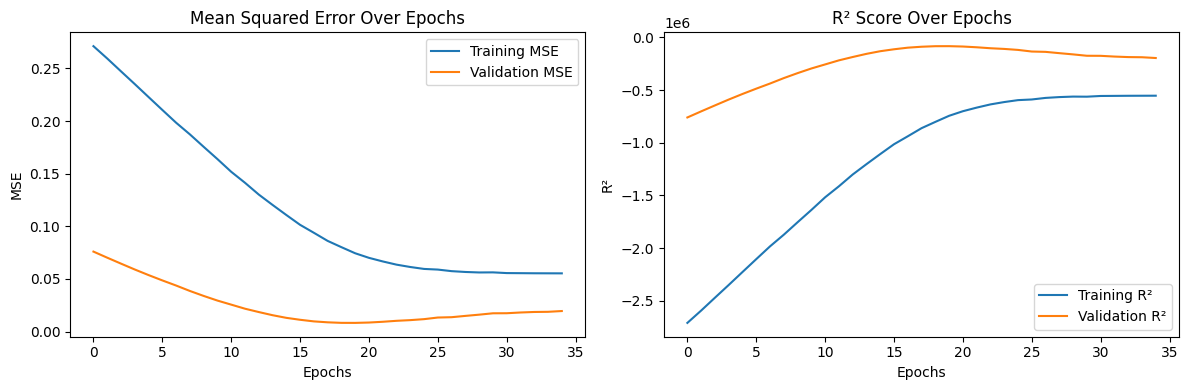

In [ ]:
import matplotlib.pyplot as plt

# Plot MSE
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['mse'], label='Training MSE')
plt.plot(history.history['val_mse'], label='Validation MSE')
plt.title('Mean Squared Error Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

# Plot R²
plt.subplot(1, 2, 2)
plt.plot(history.history['r2_keras'], label='Training R²')
plt.plot(history.history['val_r2_keras'], label='Validation R²')
plt.title('R² Score Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('R²')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Make predictions
y_pred = model.predict(X_test)

# Reshape y_test if necessary
if y_test.ndim > 1:
    y_test = y_test.reshape(-1)

# Compute R² and MSE
test_mse = mean_squared_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

print(f"Test MSE: {test_mse}")
print(f"Test R²: {test_r2}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
Test MSE: 0.008236003007193318
Test R²: -0.04381289808213973


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


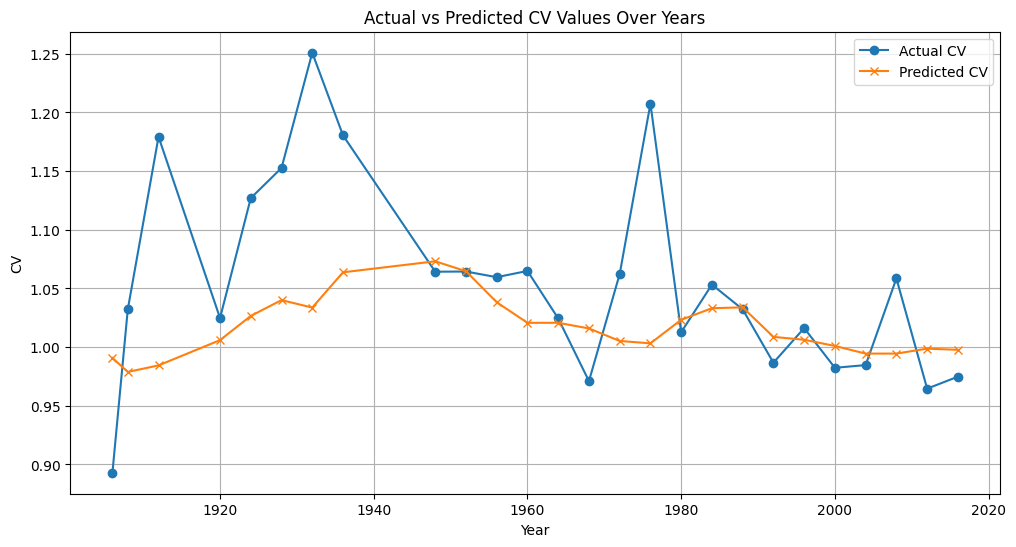

In [ ]:
# Use the same window size as during training
window_size = 3
data = df_Athletes_CV['CV_scaled'].values

# Create sequences using the function defined earlier
X_all, y_all = create_sequences(data, window_size)

# Reshape X_all for LSTM input
X_all = X_all.reshape((X_all.shape[0], X_all.shape[1], 1))
y_pred_scaled = model.predict(X_all)
# Inverse transform the predicted values
y_pred = scaler.inverse_transform(y_pred_scaled)

# Inverse transform the actual values
y_actual = scaler.inverse_transform(y_all.reshape(-1, 1))
# Extract the corresponding years from the original dataframe
years = df_Athletes_CV['Year'].values

# Adjust the years array to match the length of predictions
years = years[window_size:]
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(years, y_actual, label='Actual CV', marker='o')
plt.plot(years, y_pred, label='Predicted CV', marker='x')
plt.xlabel('Year')
plt.ylabel('CV')
plt.title('Actual vs Predicted CV Values Over Years')
plt.legend()
plt.grid(True)
plt.show()


# Attemp 2: LSTM more no. of hidden units

In [ ]:
model2 = Sequential()
model2.add(LSTM(units=128, activation='relu', input_shape=(X_train.shape[1], 1)))
model2.add(Dense(units=1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
optimizer2 = Adam(learning_rate=0.0001)
model2.compile(optimizer=optimizer2, loss='mean_squared_error', metrics=['mse', r2_keras])

In [ ]:
early_stopping2 = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=15,         # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the weights from the epoch with the best value of the monitored quantity
)

In [ ]:
history2 = model2.fit(
    X_train, y_train,
    epochs=500,                # Maximum number of epochs
    batch_size=16,              # You can adjust this based on your dataset size
    validation_data=(X_test, y_test),
    callbacks=[early_stopping2],
    verbose=1                  # Set to 1 to print progress for each epoch
)

Epoch 1/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - loss: 0.3188 - mse: 0.3188 - r2_keras: -65.6231 - val_loss: 0.0943 - val_mse: 0.0943 - val_r2_keras: -70.7309
Epoch 2/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.3131 - mse: 0.3131 - r2_keras: -76.2441 - val_loss: 0.0934 - val_mse: 0.0934 - val_r2_keras: -70.0395
Epoch 3/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2848 - mse: 0.2848 - r2_keras: -83.0728 - val_loss: 0.0925 - val_mse: 0.0925 - val_r2_keras: -69.3538
Epoch 4/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.3075 - mse: 0.3075 - r2_keras: -73.2379 - val_loss: 0.0916 - val_mse: 0.0916 - val_r2_keras: -68.6766
Epoch 5/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.3063 - mse: 0.3063 - r2_keras: -70.4321 - val_loss: 0.0907 - val_mse: 0.0907 - val_r2_keras: -68.0089
Epoch 6/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.3030 - mse: 0.3030 - r2_keras: -63.9434 - val_loss: 0.0899 - val_mse: 0.0899 - val_r2_keras: -67.3508
Epoch 7/500
2/2 ━━━━━━━━━━━━━━

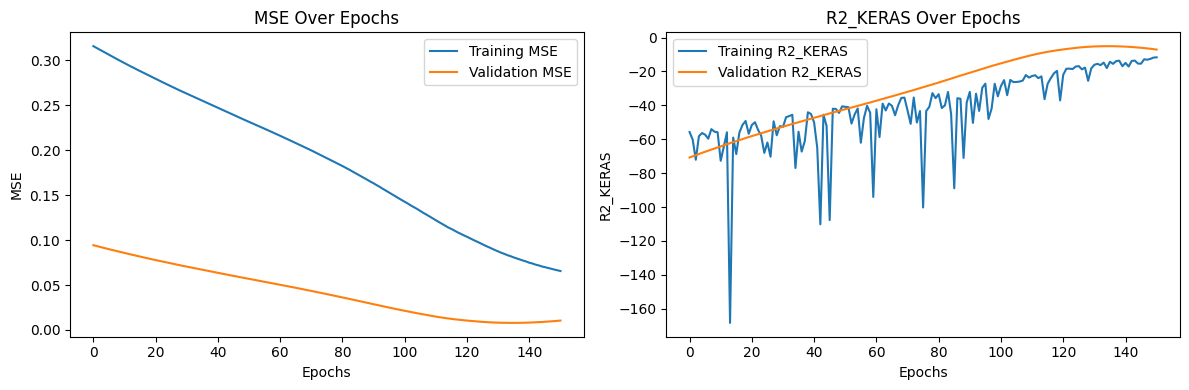

In [ ]:
plot_training_history(history2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


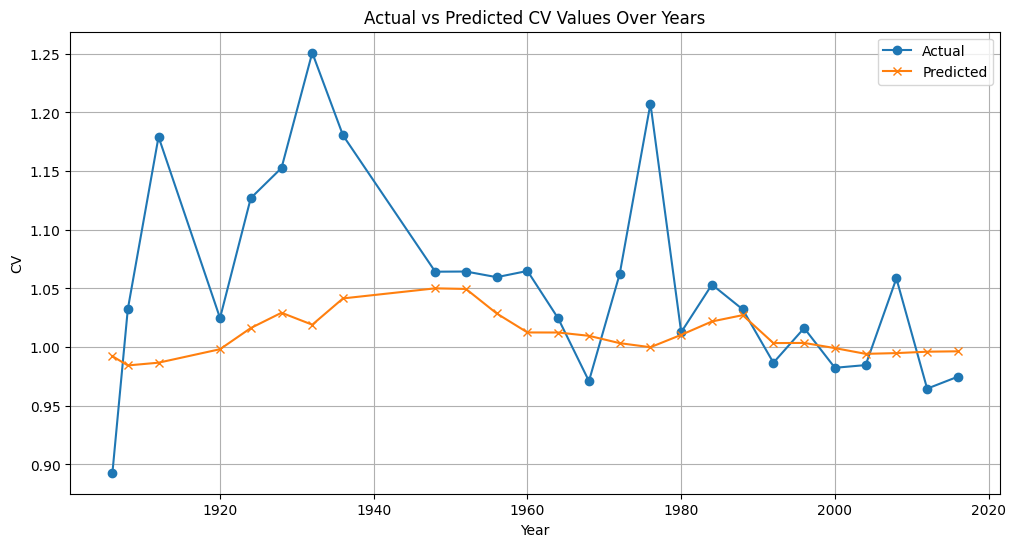

In [ ]:
plot_predictions(model=model2, data=df_Athletes_CV, window_size=3, scaler=scaler, years=df_Athletes_CV['Year'].values)

In [ ]:
y_pred = model2.predict(X_test)

# Reshape y_test if necessary
if y_test.ndim > 1:
    y_test = y_test.reshape(-1)

# Compute R² and MSE
test_mse = mean_squared_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

print(f"Test MSE: {test_mse}")
print(f"Test R²: {test_r2}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Test MSE: 0.007862517330887484
Test R²: 0.0035218546901051306


# Attemp 3: Bideirectional LSTM

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


In [ ]:
model3 = Sequential()
model3.add(Bidirectional(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], 1))))
model3.add(Dropout(0.2))
model3.add(BatchNormalization())

model3.add(Bidirectional(LSTM(units=64)))
model3.add(Dropout(0.2))
model3.add(BatchNormalization())

model3.add(Dense(units=1))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
optimizer3  = Adam(learning_rate=0.00005)  # Reduced learning rate for finer updates
model3.compile(optimizer=optimizer3, loss='mean_squared_error', metrics=['mse', r2_keras])


In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True,
    verbose=1
)

In [ ]:
history3 = model3.fit(
    X_train, y_train,
    epochs=500,  # Increased epochs due to the complexity of the model
    batch_size=2,  # Adjusted batch size
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.8310 - mse: 0.8310 - r2_keras: -349.5176 - val_loss: 0.0900 - val_mse: 0.0900 - val_r2_keras: -180.0733
Epoch 2/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6763 - mse: 0.6763 - r2_keras: -1202.4685 - val_loss: 0.0873 - val_mse: 0.0873 - val_r2_keras: -172.5479
Epoch 3/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.4517 - mse: 1.4517 - r2_keras: -328848.6875 - val_loss: 0.0838 - val_mse: 0.0838 - val_r2_keras: -163.0156
Epoch 4/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7548 - mse: 0.7548 - r2_keras: -84649.2266 - val_loss: 0.0812 - val_mse: 0.0812 - val_r2_keras: -155.6196
Epoch 5/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7630 - mse: 0.7630 - r2_keras: -2944.2620 - val_loss: 0.0781 - val_mse: 0.0781 - val_r2_keras: -147.2270
Epoch 6/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.3466 - mse: 1.3466 - r2_keras: -9169273.0000 - val_loss: 0.0757 - val_mse: 0.0757 - val_r2_keras: -14

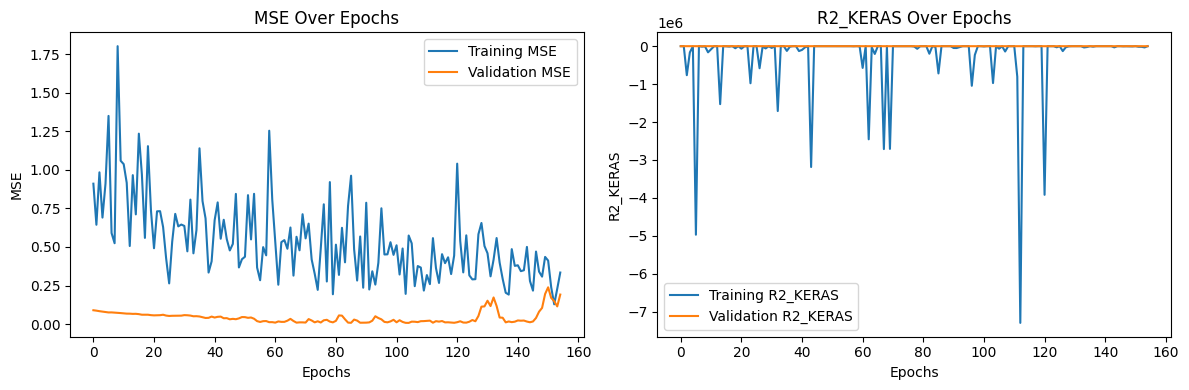

In [ ]:
plot_training_history(history3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


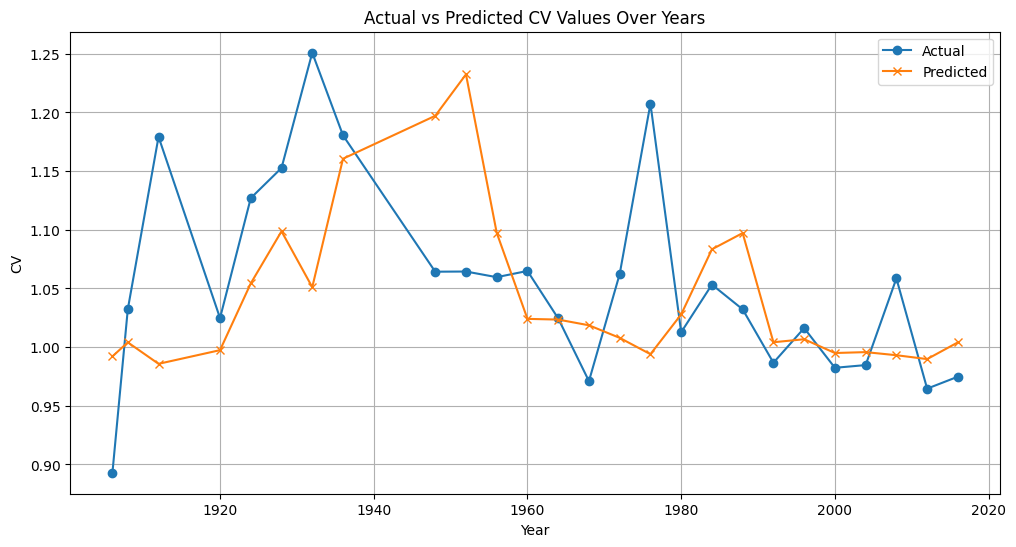

In [ ]:
plot_predictions(model=model3, data=df_Athletes_CV, window_size=3, scaler=scaler, years=df_Athletes_CV['Year'].values)

In [ ]:
y_pred = model3.predict(X_test)

# Reshape y_test if necessary
if y_test.ndim > 1:
    y_test = y_test.reshape(-1)

# Compute R² and MSE
test_mse = mean_squared_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

print(f"Test MSE: {test_mse}")
print(f"Test R²: {test_r2}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
Test MSE: 0.007995541532751359
Test R²: -0.013337339938809256


# Attempt 4: Bi-directional LSTM reconstucted

In [ ]:
model4 = Sequential()
model4.add(Bidirectional(LSTM(units=256, return_sequences=True, input_shape=(X_train.shape[1], 1))))
model4.add(Dropout(0.1))
model4.add(BatchNormalization())

model4.add(Bidirectional(LSTM(units=128)))
model4.add(Dropout(0.1))
model4.add(BatchNormalization())

model4.add(Dense(units=1))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
optimizer4  = Adam(learning_rate=0.00005)  # Reduced learning rate for finer updates
model4.compile(optimizer=optimizer4, loss='mean_squared_error', metrics=['mse', r2_keras])


In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True,
    verbose=1
)

In [ ]:
history4 = model4.fit(
    X_train, y_train,
    epochs=700,  # Increased epochs due to the complexity of the model
    batch_size=4,  # Adjusted batch size
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/700
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - loss: 2.0414 - mse: 2.0414 - r2_keras: -183.9361 - val_loss: 0.0887 - val_mse: 0.0887 - val_r2_keras: -243.9129
Epoch 2/700
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.8063 - mse: 0.8063 - r2_keras: -229.9098 - val_loss: 0.0879 - val_mse: 0.0879 - val_r2_keras: -241.1933
Epoch 3/700
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6486 - mse: 0.6486 - r2_keras: -100.1052 - val_loss: 0.0856 - val_mse: 0.0856 - val_r2_keras: -232.0529
Epoch 4/700
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.9830 - mse: 0.9830 - r2_keras: -16048.5303 - val_loss: 0.0827 - val_mse: 0.0827 - val_r2_keras: -220.9414
Epoch 5/700
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6796 - mse: 0.6796 - r2_keras: -76.2776 - val_loss: 0.0802 - val_mse: 0.0802 - val_r2_keras: -211.1079
Epoch 6/700
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.7278 - mse: 0.7278 - r2_keras: -65.5058 - val_loss: 0.0776 - val_mse: 0.0776 - val_r2_keras: -201.1659
Epoch 7/700
5/5

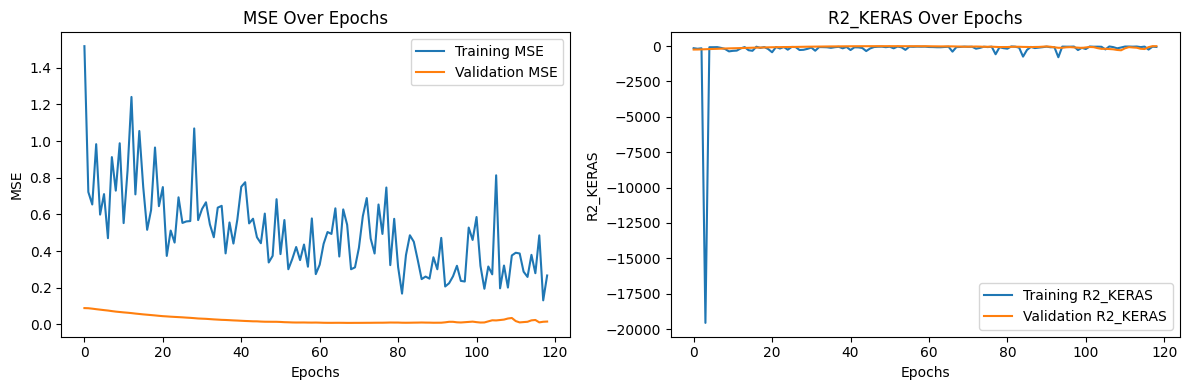

In [ ]:
plot_training_history(history4)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


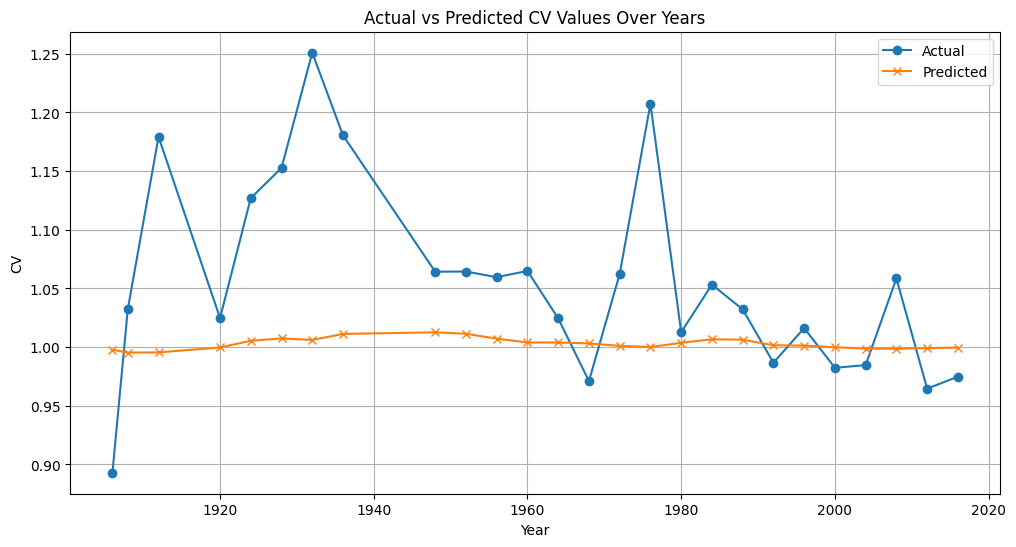

In [ ]:
plot_predictions(model=model4, data=df_Athletes_CV, window_size=3, scaler=scaler, years=df_Athletes_CV['Year'].values)

# Attempt 5: LSTM + ARIMA (Hybrid Model), not that actually bad though



In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = data_dict['Athletics']['CV']
df.head()

,Year,CV
0,1896,1.001050
1,1900,0.975667
2,1904,0.978102
3,1906,0.892952
4,1908,1.032252


In [ ]:
time_series_data = df['CV']

In [ ]:
!pip install pmdarima


In [ ]:
import pmdarima as pm

# Perform grid search for optimal ARIMA order
model = pm.auto_arima(
    time_series_data,
    start_p=0, max_p=5,      # Range for p
    start_q=0, max_q=5,      # Range for q
    d=None,                  # Automatically determine d
    start_d=0, max_d=2,      # Differencing range
    seasonal=False,          # Use seasonal=True for SARIMA
    trace=True,              # Print search progress
    error_action='ignore',   # Ignore errors during search
    suppress_warnings=True,  # Suppress warnings
    stepwise=True            # Use stepwise algorithm for efficiency
)

# Display the best model summary
print(model.summary())


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=87.167, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-54.302, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-53.264, Time=0.16 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-61.894, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-63.547, Time=0.28 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-59.452, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-61.578, Time=0.25 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-63.880, Time=0.14 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-61.884, Time=0.17 sec
 ARIMA(

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Extract the best order
best_order = model.order  # (p, d, q)

# Fit ARIMA with the optimal order
arima_model = ARIMA(time_series_data, order=best_order).fit()

# Summary of the ARIMA model
print(arima_model.summary())


                               SARIMAX Results                                
Dep. Variable:                     CV   No. Observations:                   29
Model:                 ARIMA(1, 0, 0)   Log Likelihood                  34.940
Date:                Sun, 17 Nov 2024   AIC                            -63.880
Time:                        06:22:22   BIC                            -59.778
Sample:                             0   HQIC                           -62.595
                                 - 29                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0444      0.028     36.902      0.000       0.989       1.100
ar.L1          0.4467      0.173      2.583      0.010       0.108       0.786
sigma2         0.0052      0.002      3.132      0.0

In [ ]:
model_arima = ARIMA(df['CV'], order=(1,0,0))
model_arima_fit = model_arima.fit()

# Generate in-sample predictions
df['CV_arima_pred'] = model_arima_fit.predict(start=df.index[1], end=df.index[-1])

# Calculate residuals
df['CV_residual'] = df['CV'] - df['CV_arima_pred']

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Reset index for LSTM processing
df.reset_index(inplace=True)

# Handle missing values in residuals
df['CV_residual'].fillna(method='bfill', inplace=True)

# Normalize residuals
scaler = MinMaxScaler(feature_range=(0, 1))
df['CV_residual_scaled'] = scaler.fit_transform(df['CV_residual'].values.reshape(-1,1))

# Create sequences
def create_sequences(data, window_size):
    X = []
    y = []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

window_size = 3  # Adjust as needed
data = df['CV_residual_scaled'].values
X, y = create_sequences(data, window_size)

# Split into train and test sets
split_ratio = 0.8
split_index = int(len(X) * split_ratio)

X_train = X[:split_index]
y_train = y[:split_index]
X_test = X[split_index:]
y_test = y[split_index:]

# Reshape input for LSTM [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], window_size, 1))
X_test = X_test.reshape((X_test.shape[0], window_size, 1))


In [ ]:
optimizer5  = Adam(learning_rate=0.0001)

In [ ]:
# Build LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, activation='relu', input_shape=(window_size, 1)))
model_lstm.add(Dense(units=1))

# Compile model
model_lstm.compile(optimizer=optimizer5, loss='mean_squared_error')

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# Train model
history5 = model_lstm.fit(
    X_train, y_train,
    epochs=500,
    batch_size=1,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.3391 - val_loss: 0.1325
Epoch 2/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3839 - val_loss: 0.1263
Epoch 3/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2355 - val_loss: 0.1206
Epoch 4/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3878 - val_loss: 0.1145
Epoch 5/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2686 - val_loss: 0.1091
Epoch 6/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2636 - val_loss: 0.1035
Epoch 7/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3368 - val_loss: 0.0979
Epoch 8/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2240 - val_loss: 0.0930
Epoch 9/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1878 - val_loss: 0.0877
Epoch 10/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2039 - val_loss: 0.0826
Epoch 11/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2207 - val_loss: 0.0772
Epoch 12/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.

In [ ]:
# Make predictions on the test set residuals
y_pred_residual_scaled = model_lstm.predict(X_test)

# Inverse transform the scaled residual predictions
y_pred_residual = scaler.inverse_transform(y_pred_residual_scaled)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step


In [ ]:
# Get ARIMA predictions for the test set
test_indices = df.index[window_size + split_index:]

arima_pred_test = df.loc[test_indices, 'CV_arima_pred'].values

# Combine ARIMA predictions with LSTM residual predictions
final_pred = arima_pred_test + y_pred_residual.flatten()


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Actual CV values for test set
y_actual = df.loc[test_indices, 'CV'].values

# Evaluate
mse = mean_squared_error(y_actual, final_pred)
r2 = r2_score(y_actual, final_pred)

print(f"Hybrid Model Test MSE: {mse}")
print(f"Hybrid Model Test R²: {r2}")


Hybrid Model Test MSE: 0.0015279687294593996
Hybrid Model Test R²: -0.511312168472067


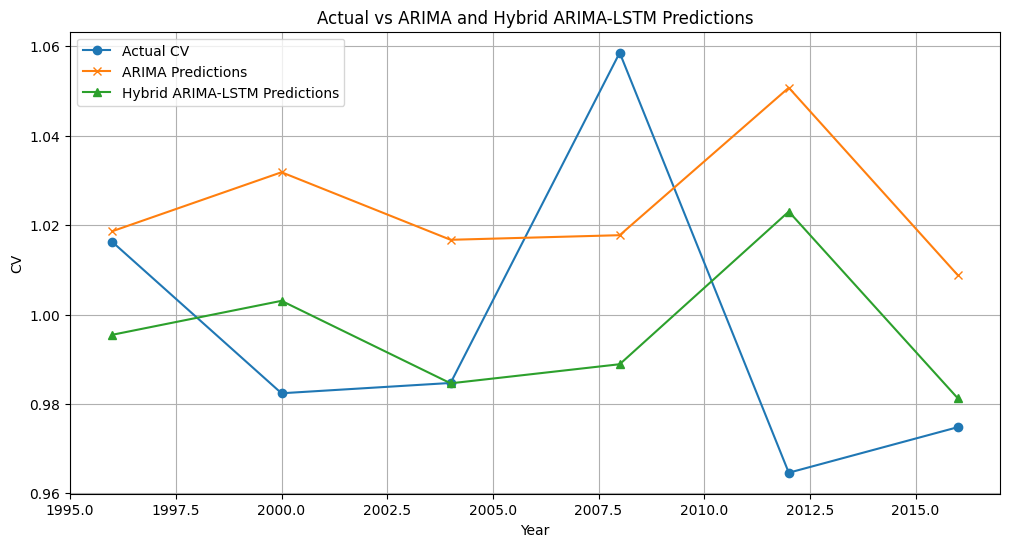

In [ ]:
import matplotlib.pyplot as plt

# Years for plotting
test_years = df.loc[test_indices, 'Year'].values

plt.figure(figsize=(12,6))
plt.plot(test_years, y_actual, label='Actual CV', marker='o')
plt.plot(test_years, arima_pred_test, label='ARIMA Predictions', marker='x')
plt.plot(test_years, final_pred, label='Hybrid ARIMA-LSTM Predictions', marker='^')
plt.xlabel('Year')
plt.ylabel('CV')
plt.title('Actual vs ARIMA and Hybrid ARIMA-LSTM Predictions')
plt.legend()
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


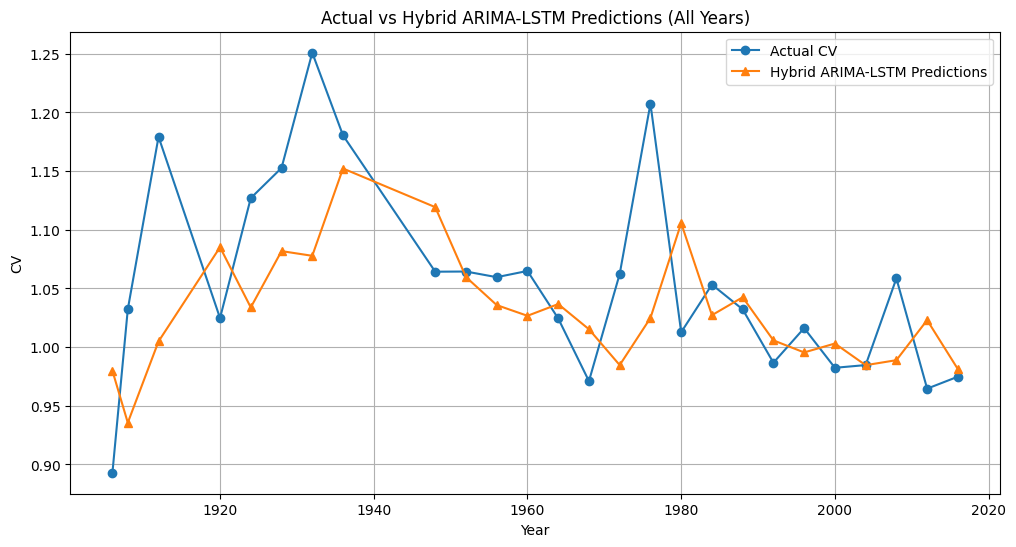

In [ ]:
# Step 1: Predict ARIMA values for all years in the DataFrame
arima_all_pred = model_arima_fit.predict(start=df.index[0], end=df.index[-1])

# Step 2: Prepare residuals for LSTM predictions (all years)
# Normalize ARIMA residuals for the entire dataset
df['CV_residual'] = df['CV'] - arima_all_pred
df['CV_residual'].fillna(method='bfill', inplace=True)
df['CV_residual_scaled'] = scaler.transform(df['CV_residual'].values.reshape(-1, 1))

# Create sequences for the entire dataset
data_all = df['CV_residual_scaled'].values
X_all, _ = create_sequences(data_all, window_size)

# Reshape input for LSTM
X_all = X_all.reshape((X_all.shape[0], window_size, 1))

# Step 3: Predict LSTM residuals for all sequences
lstm_all_residual_scaled = model_lstm.predict(X_all)

# Inverse scaling of residual predictions
lstm_all_residual = scaler.inverse_transform(lstm_all_residual_scaled)

# Step 4: Combine ARIMA predictions with LSTM residual predictions
# Extend ARIMA predictions to match the LSTM output
hybrid_all_pred = arima_all_pred[window_size:] + lstm_all_residual.flatten()

# Actual values (aligned with hybrid predictions)
actual_values = df['CV'].values[window_size:]

# Step 5: Plot actual vs. hybrid predictions
import matplotlib.pyplot as plt

# Get years corresponding to hybrid predictions
years = df['Year'].values[window_size:]

plt.figure(figsize=(12, 6))
plt.plot(years, actual_values, label='Actual CV', marker='o')
plt.plot(years, hybrid_all_pred, label='Hybrid ARIMA-LSTM Predictions', marker='^')
plt.xlabel('Year')
plt.ylabel('CV')
plt.title('Actual vs Hybrid ARIMA-LSTM Predictions (All Years)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
r2 = r2_score(actual_values, hybrid_all_pred)
print("R² value:", r2)

R² value: 0.09015289433008433


# Attempt 6: ARIMA-LSTM Hybrid: take 2

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# For ARIMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# For LSTM
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping

# For evaluation
from sklearn.metrics import mean_squared_error

In [ ]:
df = data_dict['Athletics']['CV']
ts = df['CV']
df.head()

,Year,CV
0,1896,1.001050
1,1900,0.975667
2,1904,0.978102
3,1906,0.892952
4,1908,1.032252


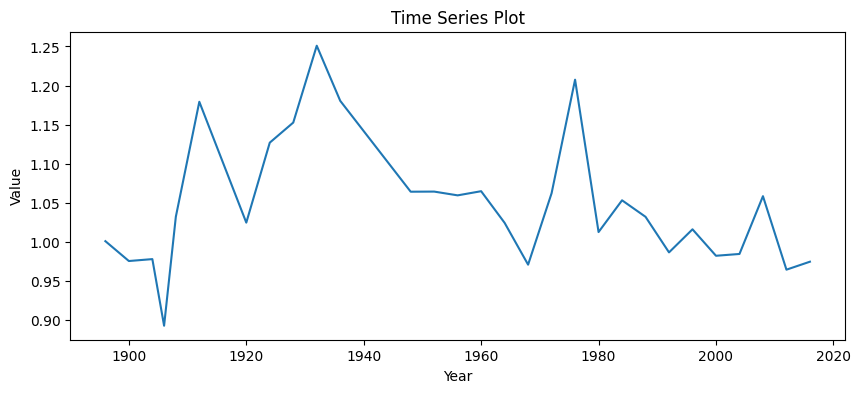

In [ ]:
# Visualize the time series
plt.figure(figsize=(10, 4))
plt.plot(ts)
plt.title('Time Series Plot')
plt.xlabel('Year')
plt.ylabel('Value')
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: {:.6f}'.format(result[0]))
    print('p-value: {:.6f}'.format(result[1]))
    if result[1] <= 0.05:
        print("The series is stationary.")
    else:
        print("The series is non-stationary.")

adf_test(ts)


ADF Statistic: -3.083080
p-value: 0.027831
The series is stationary.


In [ ]:
# Differencing the series if necessary
ts_diff = ts.diff().dropna()

# Re-run the ADF test on the differenced data
adf_test(ts_diff)


ADF Statistic: -2.724658
p-value: 0.069868
The series is non-stationary.


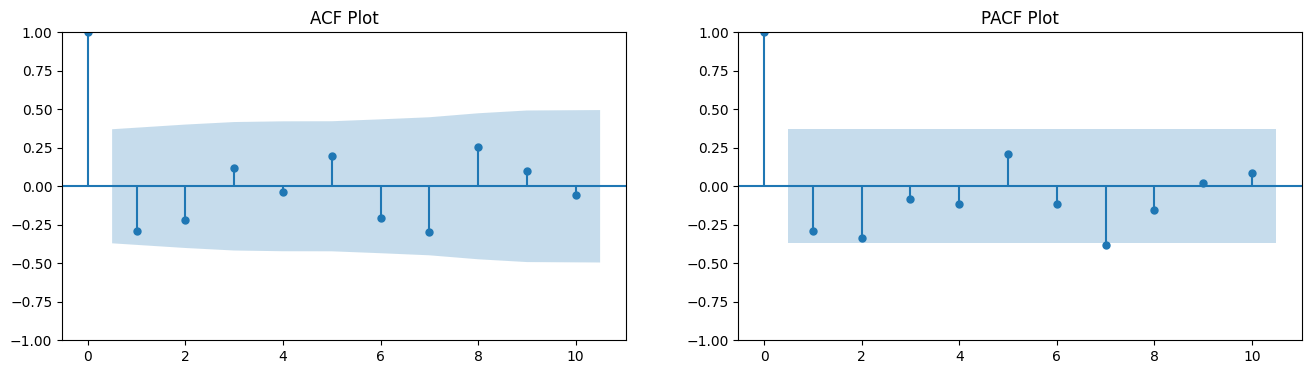

In [ ]:
# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16,4))
plot_acf(ts_diff, ax=axes[0], lags=10)
axes[0].set_title('ACF Plot')
plot_pacf(ts_diff, ax=axes[1], lags=10, method='ywm')
axes[1].set_title('PACF Plot')
plt.show()

In [ ]:
import warnings
warnings.filterwarnings("ignore")  # To ignore convergence warnings

import itertools

# Define the p, d, and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

aic_values = []
parameters = []

for param in pdq:
    try:
        model = ARIMA(ts, order=param)
        results = model.fit()
        aic_values.append(results.aic)
        parameters.append(param)
    except:
        continue

# Find the model with the lowest AIC
lowest_aic = min(aic_values)
best_params = parameters[aic_values.index(lowest_aic)]
print(f'Best ARIMA order: {best_params} with AIC: {lowest_aic}')


Best ARIMA order: (1, 0, 0) with AIC: -63.880018745343435


In [ ]:
!pip install pmdarima

import pmdarima as pm

# Use auto_arima to find the optimal parameters
model_auto = pm.auto_arima(ts, start_p=0, start_q=0,
                           max_p=5, max_q=5, d=None,
                           seasonal=False, stepwise=True,
                           suppress_warnings=True, information_criterion='aic')

print(model_auto.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   29
Model:               SARIMAX(1, 0, 0)   Log Likelihood                  34.940
Date:                Sat, 16 Nov 2024   AIC                            -63.880
Time:                        11:36:44   BIC                            -59.778
Sample:                             0   HQIC                           -62.595
                                 - 29                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.5768      0.185      3.114      0.002       0.214       0.940
ar.L1          0.4478      0.173      2.590      0.010       0.109       0.787
sigma2         0.0052      0.002      3.133      0.0

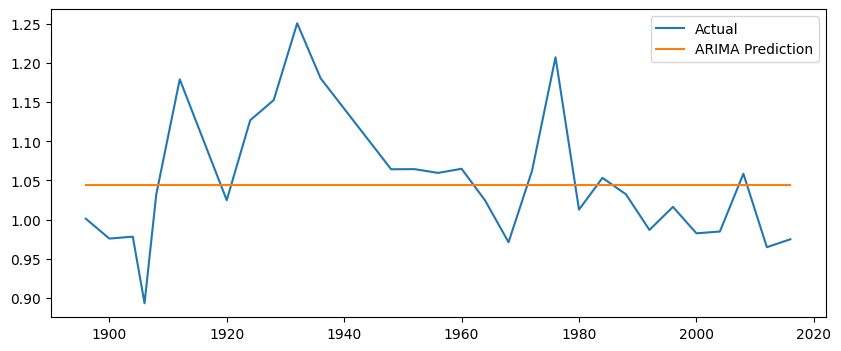

In [ ]:
# Extract the optimal (p,d,q) orders
p, d, q = model_auto.order

# Fit the ARIMA model
arima_model = ARIMA(ts, order=(p, d, q)).fit()

# ARIMA predictions
arima_pred = arima_model.predict(start=ts.index[0], end=ts.index[-1], typ='levels')

# Plot the ARIMA predictions
plt.figure(figsize=(10, 4))
plt.plot(ts, label='Actual')
plt.plot(arima_pred, label='ARIMA Prediction')
plt.legend()
plt.show()


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Attempt 7: Sarimax-hybrid LSTM (old version)



In [ ]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: {:.6f}'.format(result[0]))
    print('p-value: {:.6f}'.format(result[1]))
    if result[1] <= 0.05:
        print("The series is stationary.")
    else:
        print("The series is non-stationary.")

adf_test(ts)


ADF Statistic: -3.083080
p-value: 0.027831
The series is stationary.


In [ ]:
# Differencing the series if necessary
ts_diff = ts.diff().dropna()

# Re-run the ADF test on the differenced data
adf_test(ts_diff)


ADF Statistic: -2.724658
p-value: 0.069868
The series is non-stationary.


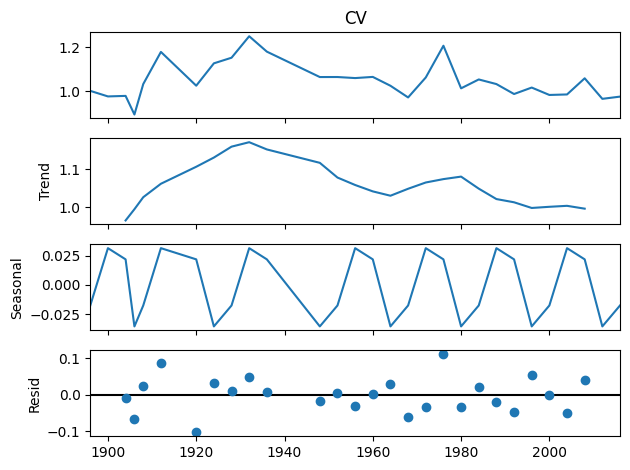

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose_result = seasonal_decompose(ts, model='additive', period=4)
decompose_result.plot()
plt.show()


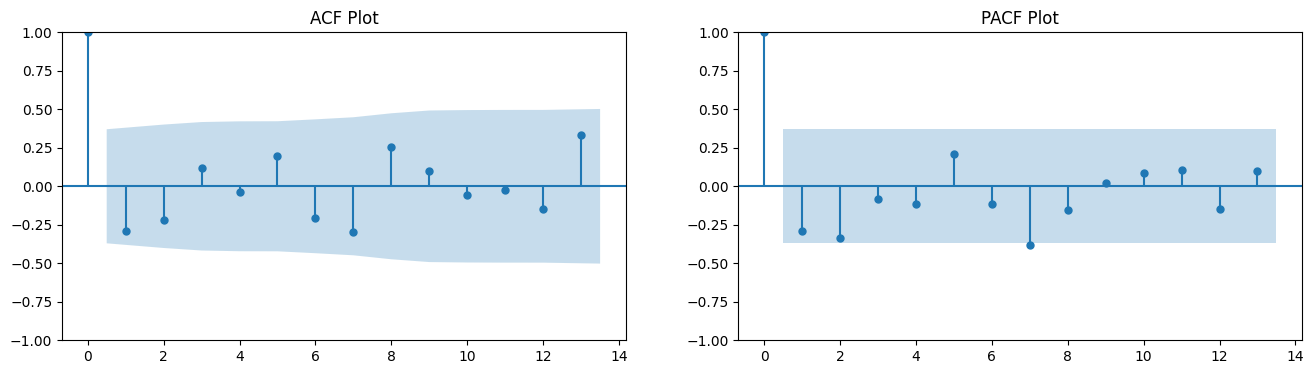

In [ ]:
# Adjust the lags based on data length
max_lag = int(len(ts) / 2) - 1  # Ensure lags < 50% of sample size

# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(ts_diff, ax=axes[0], lags=max_lag)
axes[0].set_title('ACF Plot')
plot_pacf(ts_diff, ax=axes[1], lags=max_lag, method='ywm')
axes[1].set_title('PACF Plot')
plt.show()

In [ ]:
model_auto = pm.auto_arima(ts, start_p=0, start_q=0,
                           max_p=3, max_q=3, d=None,
                           start_P=0, start_Q=0, max_P=2, max_Q=2,
                           m=4,  # Seasonal period
                           seasonal=True, trace=True,
                           error_action='ignore', suppress_warnings=True,
                           stepwise=True, information_criterion='aic')

print(model_auto.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=-59.452, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=-61.562, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=87.167, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[4] intercept   : AIC=-63.547, Time=0.10 sec
 ARIMA(0,0,1)(1,0,0)[4] intercept   : AIC=-28.196, Time=0.21 sec
 ARIMA(0,0,1)(1,0,1)[4] intercept   : AIC=-59.617, Time=0.26 sec
 ARIMA(1,0,1)(0,0,0)[4] intercept   : AIC=-61.894, Time=0.17 sec
 ARIMA(0,0,2)(0,0,0)[4] intercept   : AIC=-61.578, Time=0.21 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=-63.880, Time=0.14 sec
 ARIMA(1,0,0)(0,0,1)[4] intercept   : AIC=-61.882, Time=0.89 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=-59.880, Time=1.61 sec
 ARIMA(2,0,0)(0,0,0)[4] intercept   : AIC=-61.884, Time=0.24 sec
 ARIMA(2,0,1)(0,0,0)[4] intercept   : AIC=-59.944, Time=0.33 sec
 ARIMA(1,0,0)(0,0,0)[4]             : AIC=inf, Time=

In [ ]:
order = model_auto.order
seasonal_order = model_auto.seasonal_order
sarimax_model = SARIMAX(ts, order=order, seasonal_order=seasonal_order).fit(disp=False)
sarimax_pred = sarimax_model.predict(start=ts.index[0], end=ts.index[-1])

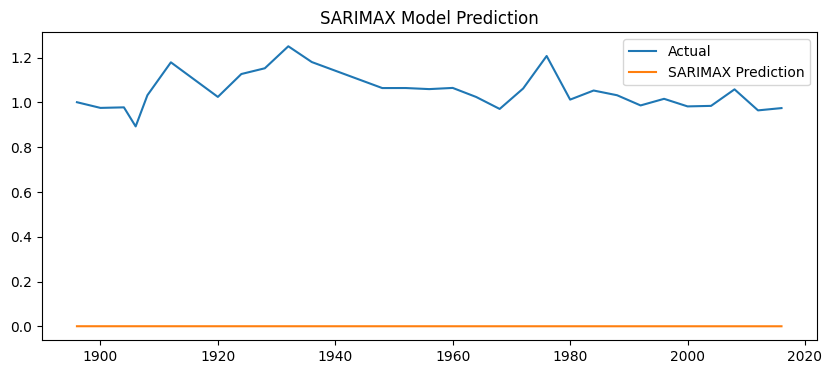

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(ts, label='Actual')
plt.plot(sarimax_pred, label='SARIMAX Prediction')
plt.legend()
plt.title('SARIMAX Model Prediction')
plt.show()

# Attempt 8: GRU

In [ ]:
from keras.layers import GRU, Dense, Dropout

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(ts)
plt.title('Time Series Plot')
plt.xlabel('Year')
plt.ylabel('Value')
plt.show()

In [ ]:
# Split the data into training and testing sets
train_size = int(len(ts) * 0.8)  # Use 80% for training
test_size = len(ts) - train_size

train_ts = ts.iloc[:train_size]
test_ts = ts.iloc[train_size:]

print(f'Training data points: {len(train_ts)}')
print(f'Testing data points: {len(test_ts)}')


In [ ]:
# Initialize the scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit the scaler on the training data and transform both training and testing data
train_scaled = scaler.fit_transform(train_ts.values.reshape(-1, 1))
test_scaled = scaler.transform(test_ts.values.reshape(-1, 1))


In [ ]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 1  # Using a sequence length of 1 due to limited data

# Create sequences for training
X_train, y_train = create_sequences(train_scaled, seq_length)

# Create sequences for testing
X_test, y_test = create_sequences(test_scaled, seq_length)

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], seq_length, 1))
X_test = X_test.reshape((X_test.shape[0], seq_length, 1))

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')


In [ ]:
from keras.regularizers import l2

# Define the GRU model
model_gru = Sequential()
model_gru.add(GRU(units=64, activation='relu', input_shape=(seq_length, 1),
              kernel_regularizer=l2(0.0005)))
model_gru.add(Dropout(0.2))  # Dropout to prevent overfitting
model_gru.add(Dense(units=1))
optimizer_gru = Adam(learning_rate=0.0001)
# Compile the model
model_gru.compile(optimizer=optimizer_gru , loss='mean_squared_error')


In [ ]:
# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Fit the model
history_gru = model_gru.fit(X_train, y_train, epochs=500, batch_size=1,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stop], verbose=0)

# Plot training and validation loss
plt.figure(figsize=(10, 4))
plt.plot(history_gru.history['loss'], label='Training Loss')
plt.plot(history_gru.history['val_loss'], label='Validation Loss')
plt.title('GRU Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Predict on training data
train_pred_scaled = model_gru.predict(X_train)
train_pred = scaler.inverse_transform(train_pred_scaled)
y_train_actual = scaler.inverse_transform(y_train)

# Predict on testing data
test_pred_scaled = model_gru.predict(X_test)
test_pred = scaler.inverse_transform(test_pred_scaled)
y_test_actual = scaler.inverse_transform(y_test)


In [ ]:
# Calculate RMSE for training data
train_rmse = np.sqrt(mean_squared_error(y_train_actual, train_pred))
print(f'Training RMSE: {train_rmse:.4f}')

# Calculate RMSE for testing data
test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_pred))
print(f'Testing RMSE: {test_rmse:.4f}')

# Plot the results
plt.figure(figsize=(12, 6))

# Plot training results
plt.subplot(1, 2, 1)
plt.plot(train_ts.index[seq_length:], y_train_actual, label='Actual', marker='o')
plt.plot(train_ts.index[seq_length:], train_pred, label='Predicted', marker='o')
plt.title('Training Data')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()

# Plot testing results
plt.subplot(1, 2, 2)
plt.plot(test_ts.index[seq_length:], y_test_actual, label='Actual', marker='o')
plt.plot(test_ts.index[seq_length:], test_pred, label='Predicted', marker='o')
plt.title('Testing Data')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()

plt.tight_layout()
plt.show()


# Attempt 9: Sarimax-LSTM Hybrid (new ver.)

In [ ]:
# Perform grid search for optimal SARIMAX order
# Adjust 'm' based on your data frequency (e.g., m=12 for monthly data)
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import pmdarima as pm

import matplotlib.pyplot as plt
df = data_dict['Athletics']['CV']
df.head()
time_series_data = df['CV']


model_grid = pm.auto_arima(
    time_series_data,
    start_p=0, max_p=5,
    start_q=0, max_q=5,
    d=None,
    start_d=0, max_d=2,
    seasonal=True,
    m=1,  # Set to appropriate seasonal period
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

# Display the best model summary
print(model_grid.summary())

# Extract the best order and seasonal order
best_order = model_grid.order
best_seasonal_order = model_grid.seasonal_order

print(f"Best order: {best_order}")
print(f"Best seasonal order: {best_seasonal_order}")

# Fit SARIMAX with the optimal order
sarimax2_model = SARIMAX(time_series_data, order=best_order, seasonal_order=best_seasonal_order).fit()

# Summary of the SARIMAX model
print(sarimax2_model.summary())

# Generate in-sample predictions
df['CV_sarimax_pred'] = sarimax2_model.predict(start=df.index[0], end=df.index[-1])

# Calculate residuals
df['CV_residual'] = df['CV'] - df['CV_sarimax_pred']

# Handle missing values in residuals
df['CV_residual'].fillna(method='bfill', inplace=True)

# Normalize residuals
scaler = MinMaxScaler(feature_range=(0, 1))
df['CV_residual_scaled'] = scaler.fit_transform(df['CV_residual'].values.reshape(-1, 1))

# Function to create sequences for LSTM
def create_sequences(data, window_size):
    X = []
    y = []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# Create sequences
window_size = 3  # Adjust as needed
data = df['CV_residual_scaled'].values
X, y = create_sequences(data, window_size)

# Split into train and test sets
split_ratio = 0.8
split_index = int(len(X) * split_ratio)

X_train = X[:split_index]
y_train = y[:split_index]
X_test = X[split_index:]
y_test = y[split_index:]

# Reshape input for LSTM [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], window_size, 1))
X_test = X_test.reshape((X_test.shape[0], window_size, 1))

# Build LSTM model
optimizer = Adam(learning_rate=0.0001)
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, activation='relu', input_shape=(window_size, 1)))
model_lstm.add(Dense(units=1))

# Compile model
model_lstm.compile(optimizer=optimizer, loss='mean_squared_error')

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# Train model
history = model_lstm.fit(
    X_train, y_train,
    epochs=500,
    batch_size=1,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1
)

# Make predictions on the test set residuals
y_pred_residual_scaled = model_lstm.predict(X_test)

# Inverse transform the scaled residual predictions
y_pred_residual = scaler.inverse_transform(y_pred_residual_scaled)

# Get SARIMAX predictions for the test set
test_indices = df.index[window_size + split_index:]
sarimax_pred_test = df.loc[test_indices, 'CV_sarimax_pred'].values

# Combine SARIMAX predictions with LSTM residual predictions
final_pred = sarimax_pred_test + y_pred_residual.flatten()

# Actual CV values for test set
y_actual = df.loc[test_indices, 'CV'].values

# Evaluate
mse = mean_squared_error(y_actual, final_pred)
r2 = r2_score(y_actual, final_pred)

print(f"Hybrid Model Test MSE: {mse}")
print(f"Hybrid Model Test R²: {r2}")

# Plot actual vs SARIMAX and hybrid predictions
test_years = df.loc[test_indices, 'Year'].values

plt.figure(figsize=(12, 6))
plt.plot(test_years, y_actual, label='Actual CV', marker='o')
plt.plot(test_years, sarimax_pred_test, label='SARIMAX Predictions', marker='x')
plt.plot(test_years, final_pred, label='Hybrid SARIMAX-LSTM Predictions', marker='^')
plt.xlabel('Year')
plt.ylabel('CV')
plt.title('Actual vs SARIMAX and Hybrid SARIMAX-LSTM Predictions')
plt.legend()
plt.grid(True)
plt.show()

# Predict SARIMAX values for all years in the DataFrame
sarimax_all_pred = sarimax2_model.predict(start=df.index[0], end=df.index[-1])

# Prepare residuals for LSTM predictions (all years)
df['CV_residual'] = df['CV'] - sarimax_all_pred
df['CV_residual'].fillna(method='bfill', inplace=True)
df['CV_residual_scaled'] = scaler.transform(df['CV_residual'].values.reshape(-1, 1))

# Create sequences for the entire dataset
data_all = df['CV_residual_scaled'].values
X_all, _ = create_sequences(data_all, window_size)

# Reshape input for LSTM
X_all = X_all.reshape((X_all.shape[0], window_size, 1))

# Predict LSTM residuals for all sequences
lstm_all_residual_scaled = model_lstm.predict(X_all)
lstm_all_residual = scaler.inverse_transform(lstm_all_residual_scaled)

# Combine SARIMAX predictions with LSTM residual predictions
hybrid_all_pred = sarimax_all_pred[window_size:] + lstm_all_residual.flatten()

# Actual values (aligned with hybrid predictions)
actual_values = df['CV'].values[window_size:]

# Plot actual vs hybrid predictions for all years
years = df['Year'].values[window_size:]

plt.figure(figsize=(12, 6))
plt.plot(years, actual_values, label='Actual CV', marker='o')
plt.plot(years, hybrid_all_pred, label='Hybrid SARIMAX-LSTM Predictions', marker='^')
plt.xlabel('Year')
plt.ylabel('CV')
plt.title('Actual vs Hybrid SARIMAX-LSTM Predictions (All Years)')
plt.legend()
plt.grid(True)
plt.show()


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-59.452, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-63.880, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-63.547, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=87.167, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-61.884, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-61.894, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-59.944, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.534 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   29
Model:               SARIMAX(1, 0, 0)   Log Likelihood                  34.940
Date:                Sun, 17 Nov 2024   AIC                            -63.880
Time:                        08:30:27   BIC      

KeyboardInterrupt: 

Training models for Sport: Alpine Skiing, Variable: drug
Error training ARIMA for Alpine Skiing - drug: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)
Training models for Sport: Alpine Skiing, Variable: equity
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


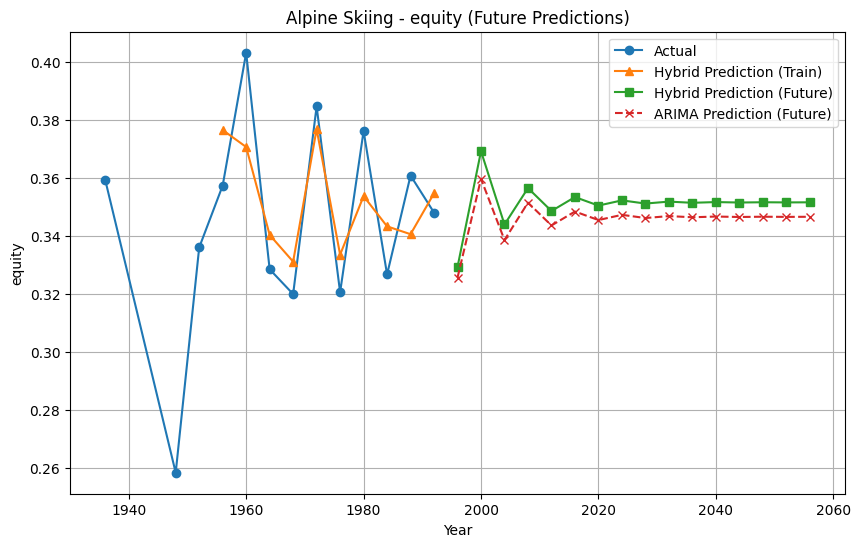

Training models for Sport: Alpine Skiing, Variable: popularity
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


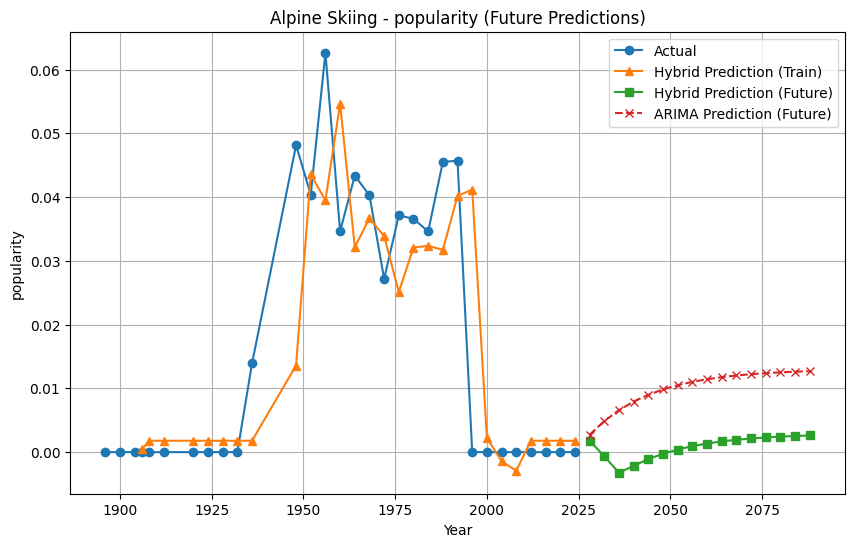

Training models for Sport: Alpine Skiing, Variable: normalized_country
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


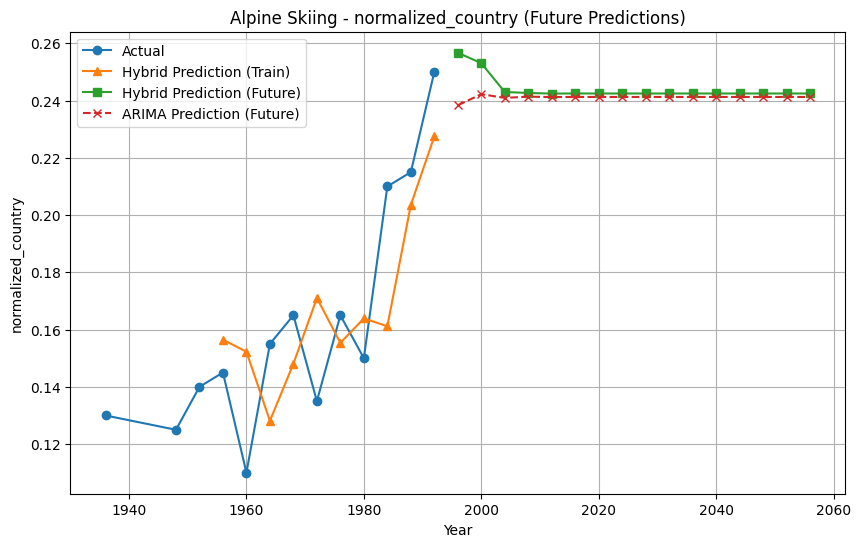

Training models for Sport: Alpine Skiing, Variable: CV
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


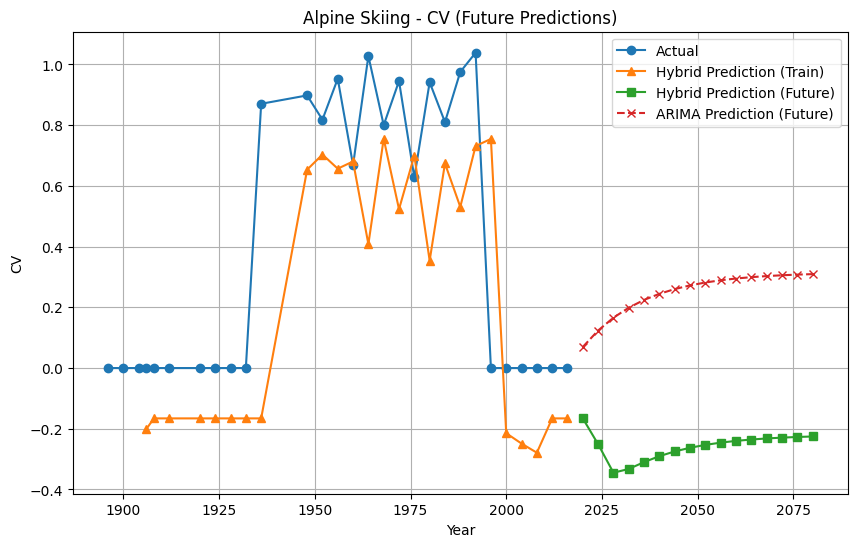

Training models for Sport: Alpinism, Variable: drug
Error training ARIMA for Alpinism - drug: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)
Training models for Sport: Alpinism, Variable: equity
Insufficient data for LSTM for Alpinism - equity. Skipping.
Training models for Sport: Alpinism, Variable: popularity
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━

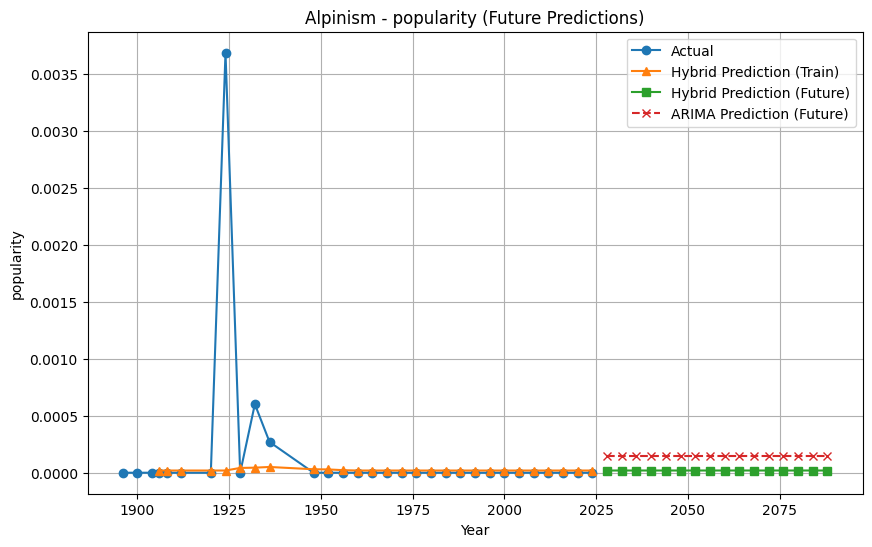

Training models for Sport: Alpinism, Variable: normalized_country
Insufficient data for LSTM for Alpinism - normalized_country. Skipping.
Training models for Sport: Alpinism, Variable: CV
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


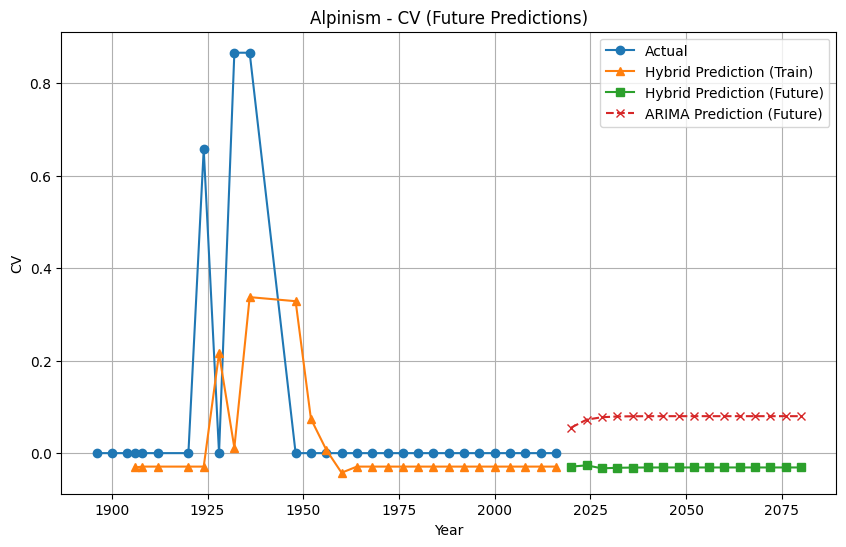

Training models for Sport: Archery, Variable: drug
Error training ARIMA for Archery - drug: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)
Training models for Sport: Archery, Variable: equity
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


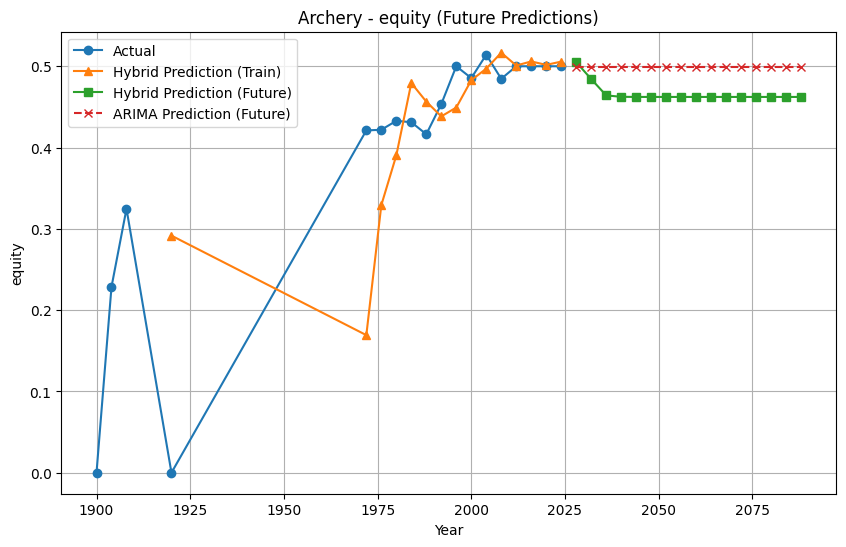

Training models for Sport: Archery, Variable: popularity


KeyboardInterrupt: 

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import pmdarima as pm
import warnings
warnings.filterwarnings("ignore")

# Function to create sequences for LSTM
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# Dictionary to store models and predictions
model_dict = {}
predictions_dict = {}

# Parameters for LSTM and ARIMA
window_size = 3
lstm_units = 50
epochs = 500
batch_size = 1
learning_rate = 0.0001
future_steps = 16  # Number of future predictions
year_interval = 4  # Interval for future years

for sport, variables in data_dict.items():
    model_dict[sport] = {}
    predictions_dict[sport] = {}

    for variable, df in variables.items():
        print(f"Training models for Sport: {sport}, Variable: {variable}")

        # Handle missing values
        df = df.sort_values(by='Year').reset_index(drop=True)  # Ensure chronological order
        time_series_data = df[variable].values

        # Skip if all values are NaN
        if np.all(np.isnan(time_series_data)):
            print(f"All values are NaN for {sport} - {variable}. Skipping.")
            continue

        # Fill missing values for ARIMA
        filled_data = df[variable].fillna(method='bfill')  # Backfill for ARIMA
        df['Residual'] = filled_data

        # Train ARIMA model
        try:
            arima_model = pm.auto_arima(
                filled_data,
                start_p=0, max_p=5,
                start_q=0, max_q=5,
                seasonal=False,
                stepwise=True,
                suppress_warnings=True,
                error_action='ignore'
            )
            arima_order = arima_model.order
            arima_fit = ARIMA(filled_data, order=arima_order).fit()
            df['ARIMA_Pred'] = arima_fit.predict(start=df.index[0], end=df.index[-1])
        except Exception as e:
            print(f"Error training ARIMA for {sport} - {variable}: {e}")
            continue

        # Calculate residuals and normalize
        df['Residual'] = df[variable] - df['ARIMA_Pred']
        scaler = MinMaxScaler(feature_range=(0, 1))
        df['Residual_Scaled'] = scaler.fit_transform(
            df['Residual'].fillna(0).values.reshape(-1, 1)  # Handle NaN residuals for LSTM
        )

        # Create sequences for LSTM
        data = df['Residual_Scaled'].values
        X, y = create_sequences(data, window_size)

        if len(X) == 0:  # Skip if insufficient data for LSTM
            print(f"Insufficient data for LSTM for {sport} - {variable}. Skipping.")
            continue

        # Split into train/test
        split_idx = int(len(X) * 0.8)
        X_train, X_test = X[:split_idx], X[split_idx:]
        y_train, y_test = y[:split_idx], y[split_idx:]
        X_train = X_train.reshape((X_train.shape[0], window_size, 1))
        X_test = X_test.reshape((X_test.shape[0], window_size, 1))

        # Build and train LSTM model
        model_lstm = Sequential()
        model_lstm.add(LSTM(units=lstm_units, activation='relu', input_shape=(window_size, 1)))
        model_lstm.add(Dense(units=1))
        model_lstm.compile(optimizer='adam', loss='mean_squared_error')
        early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
        model_lstm.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=0)

        # Predict residuals for all data
        X_all = create_sequences(data, window_size)[0]
        X_all = X_all.reshape((X_all.shape[0], window_size, 1))
        lstm_residual_pred_scaled = model_lstm.predict(X_all)
        lstm_residual_pred = scaler.inverse_transform(lstm_residual_pred_scaled)

        # Combine ARIMA and LSTM predictions
        hybrid_pred = df['ARIMA_Pred'].iloc[window_size:].values + lstm_residual_pred.flatten()

        # Predict future ARIMA values
        future_arima_pred = arima_fit.forecast(steps=future_steps)

        # Generate LSTM input for future residuals
        future_residuals_input = np.zeros((future_steps, window_size, 1))
        if len(data) >= window_size:
            future_residuals_input[0] = data[-window_size:].reshape(-1, 1)

        # Predict future residuals with LSTM
        future_residual_scaled = []
        for i in range(future_steps):
            next_residual = model_lstm.predict(future_residuals_input[i:i + 1])
            future_residual_scaled.append(next_residual[0][0])
            if i < future_steps - 1:
                future_residuals_input[i + 1, 1:] = future_residuals_input[i, :-1]
                future_residuals_input[i + 1, -1] = next_residual

        # Inverse transform residuals to original scale
        future_residuals = scaler.inverse_transform(np.array(future_residual_scaled).reshape(-1, 1))

        # Combine ARIMA and LSTM predictions for the future
        future_hybrid_pred = future_arima_pred + future_residuals.flatten()
        future_years = np.arange(df['Year'].iloc[-1] + year_interval,
                                 df['Year'].iloc[-1] + year_interval * (future_steps + 1),
                                 year_interval)

        # Save models and predictions
        model_dict[sport][variable] = {
            'ARIMA': arima_fit,
            'LSTM': model_lstm
        }
        predictions_dict[sport][variable] = {
            'Actual': df[variable].iloc[window_size:].values,
            'Hybrid': hybrid_pred,
            'Future Hybrid': future_hybrid_pred,
            'ARIMA': df['ARIMA_Pred'].iloc[window_size:].values
        }

        # Plot predictions
        plt.figure(figsize=(10, 6))
        plt.plot(df['Year'], df[variable], label='Actual', marker='o')
        plt.plot(df['Year'].iloc[window_size:], hybrid_pred, label='Hybrid Prediction (Train)', marker='^')
        plt.plot(future_years, future_hybrid_pred, label='Hybrid Prediction (Future)', marker='s')
        plt.plot(future_years, future_arima_pred, label='ARIMA Prediction (Future)', linestyle='--', marker='x')
        plt.title(f'{sport} - {variable} (Future Predictions)')
        plt.xlabel('Year')
        plt.ylabel(variable)
        plt.legend()
        plt.grid()
        plt.show()

print("Model training and future prediction visualization complete!")


In [ ]:
print(df.columns)


Index(['Unnamed: 0', 'Sport_-1', 'drug_1896', 'equity_1896', 'drug_1900',
       'equity_1900', 'drug_1904', 'equity_1904', 'drug_1906', 'equity_1906',
       ...
       'CV_1980', 'CV_1984', 'CV_1988', 'CV_1992', 'CV_1996', 'CV_2000',
       'CV_2004', 'CV_2008', 'CV_2012', 'CV_2016'],
      dtype='object', length=187)


# Attempt 10: Multi-head LSTM

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt

def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# Build Multi-head LSTM model
def build_multi_head_lstm(input_shapes, lstm_units=50, dense_units=64):
    inputs = []
    lstm_outputs = []

    # Create separate LSTM head for each input feature
    for shape in input_shapes:
        inp = Input(shape=(shape[0], 1))  # Input shape (window_size, 1)
        lstm_out = LSTM(units=lstm_units, activation='relu')(inp)
        inputs.append(inp)
        lstm_outputs.append(lstm_out)

    # Concatenate outputs of all LSTM heads
    concatenated = Concatenate()(lstm_outputs)

    # Add dense layers for combining features
    dense_out = Dense(dense_units, activation='relu')(concatenated)
    output = Dense(1)(dense_out)  # Final single output

    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


In [ ]:
window_size = 3
lstm_units = 50
dense_units = 64
epochs = 500
batch_size = 32
future_steps = 5  # Number of future points to predict

# Dictionary to store models and predictions
model_dict = {}
predictions_dict = {}

for sport, variables in data_dict.items():
    print(f"Training Multi-head LSTM for sport: {sport}")
    X_data = []
    y_data = None

    # Prepare data for each variable
    variable_names = []
    target_variable = 'CV'  # Specify the target variable
    for variable, df in variables.items():
        print(f"Processing variable: {variable}")
        df = df.sort_values(by='Year').reset_index(drop=True)  # Ensure chronological order

        # Handle missing values and extract time series
        time_series = df[variable].fillna(method='bfill').values  # Handle missing values

        # Create sequences
        X, y = create_sequences(time_series, window_size)
        X_data.append(X)
        variable_names.append(variable)

        if variable == target_variable:
            y_data = y  # Set target variable

    # Check if target variable was found
    if y_data is None:
        raise ValueError(f"Target variable '{target_variable}' not found in variables: {variable_names}")

    # Ensure all variables have the same sequence length
    min_len = min(len(x) for x in X_data)
    X_data = [x[:min_len] for x in X_data]
    y_data = y_data[:min_len]

    # Reshape X_data for LSTM input
    X_data = [x.reshape((x.shape[0], x.shape[1], 1)) for x in X_data]

    # Prepare input shapes for Multi-head LSTM
    input_shapes = [(window_size,) for _ in X_data]

    # Build and train the Multi-head LSTM model
    model = build_multi_head_lstm(input_shapes, lstm_units=lstm_units, dense_units=dense_units)

    # Split data into train/test sets
    split_idx = int(len(y_data) * 0.8)
    X_train = [x[:split_idx] for x in X_data]
    y_train = y_data[:split_idx]
    X_test = [x[split_idx:] for x in X_data]
    y_test = y_data[split_idx:]

    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping],
        verbose=1
    )

    # Predict on test set
    y_pred = model.predict(X_test)

    # Save the model and predictions
    model_dict[sport] = model
    predictions_dict[sport] = {
        'Actual': y_test,
        'Predicted': y_pred.flatten(),
        'Variable Names': variable_names
    }

    # Backtesting
    backtest_predictions = []
    for i in range(window_size, len(y_data)):
        input_sequence = [x[i - window_size:i] for x in X_data]
        input_sequence = [seq.reshape((1, window_size, 1)) for seq in input_sequence]
        pred = model.predict(input_sequence)
        backtest_predictions.append(pred[0][0])

    # Future Predictions
    future_predictions = []
    last_sequences = [x[-window_size:] for x in X_data]  # Get the last sequences for each variable
    for _ in range(future_steps):
        input_sequence = [seq.reshape((1, window_size, 1)) for seq in last_sequences]
        future_pred = model.predict(input_sequence)
        future_predictions.append(future_pred[0][0])

        # Update last sequences with the new prediction for target variable
        for j in range(len(last_sequences)):
            # Shift sequence to the left
            last_sequences[j] = np.roll(last_sequences[j], -1, axis=0)
            if variable_names[j] == target_variable:
                # For target variable, append the predicted value
                last_sequences[j][-1] = future_pred[0][0]
            else:
                # For other variables, keep the last known value (or implement your own strategy)
                last_sequences[j][-1] = last_sequences[j][-2]

    # Plot actual vs predicted values and future predictions
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(y_test)), y_test, label='Actual (Test)', marker='o')
    plt.plot(range(len(y_pred)), y_pred.flatten(), label='Predicted (Test)', marker='x')
    plt.plot(range(window_size, len(backtest_predictions) + window_size), backtest_predictions, label='Backtesting', linestyle='--')
    plt.plot(range(len(y_test), len(y_test) + future_steps), future_predictions, label='Future Predictions', marker='s')
    plt.title(f"Multi-head LSTM Predictions for {sport}")
    plt.xlabel("Time Index")
    plt.ylabel("Value")
    plt.legend()
    plt.grid()
    plt.show()

print("Training, backtesting, and future prediction visualization complete!")

Training Multi-head LSTM for sport: Alpine Skiing
Processing variable: drug
Processing variable: equity
Processing variable: popularity
Processing variable: normalized_country
Processing variable: CV


IndexError: tuple index out of range

# Attempt 11: LSTM with BAyesian Optimization

In [ ]:
# Install keras-tuner if not already installed
!pip install keras-tuner -q

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, RMSprop
import pmdarima as pm

import matplotlib.pyplot as plt

# Keras Tuner libraries
import keras_tuner as kt

# Load your data



In [ ]:
df = data_dict['Athletics']['CV']
time_series_data = df['CV']

# Perform grid search for optimal SARIMAX order using auto_arima
model_grid = pm.auto_arima(
    time_series_data,
    start_p=0, max_p=5,
    start_q=0, max_q=5,
    d=None,
    start_d=0, max_d=2,
    seasonal=True,
    m=1,  # Set to appropriate seasonal period
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

# Extract the best order and seasonal order
best_order = model_grid.order
best_seasonal_order = model_grid.seasonal_order

# Fit SARIMAX with the optimal order
sarimax2_model = SARIMAX(time_series_data, order=best_order, seasonal_order=best_seasonal_order).fit()

# Generate in-sample predictions
df['CV_sarimax_pred'] = sarimax2_model.predict(start=df.index[0], end=df.index[-1])

# Calculate residuals
df['CV_residual'] = df['CV'] - df['CV_sarimax_pred']

# Handle missing values in residuals
df['CV_residual'].fillna(method='bfill', inplace=True)

# Normalize residuals
scaler = MinMaxScaler(feature_range=(0, 1))
df['CV_residual_scaled'] = scaler.fit_transform(df['CV_residual'].values.reshape(-1, 1))

# Function to create sequences for LSTM
def create_sequences(data, window_size):
    X = []
    y = []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# Prepare data for hyperparameter tuning
def prepare_data(window_size, return_X_y=False):
    # Create sequences
    data = df['CV_residual_scaled'].values
    X, y = create_sequences(data, window_size)

    # Split into train and test sets
    split_ratio = 0.8
    split_index = int(len(X) * split_ratio)

    X_train = X[:split_index]
    y_train = y[:split_index]
    X_val = X[split_index:]
    y_val = y[split_index:]

    # Reshape input for LSTM [samples, time steps, features]
    X_train = X_train.reshape((X_train.shape[0], window_size, 1))
    X_val = X_val.reshape((X_val.shape[0], window_size, 1))

    if return_X_y:
        return X, y, X_train, y_train, X_val, y_val
    else:
        return X_train, y_train, X_val, y_val




Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-59.452, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-63.880, Time=0.22 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-63.547, Time=2.94 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=87.167, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-61.884, Time=2.28 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-61.894, Time=1.31 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-59.944, Time=0.93 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 7.955 seconds


In [ ]:
# Hypermodel function for Keras Tuner
def build_model(hp):
    window_size = hp.Int('window_size', min_value=2, max_value=10, step=1)
    X_train, y_train, X_val, y_val = prepare_data(window_size)

    model = Sequential()
    model.add(LSTM(
        units=hp.Int('units', min_value=16, max_value=128, step=16),
        activation=hp.Choice('activation', values=['relu', 'tanh']),
        input_shape=(window_size, 1)
    ))
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(units=1))

    optimizer_choice = hp.Choice('optimizer', values=['adam', 'rmsprop'])
    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=hp.Float('learning_rate', 1e-5, 1e-2, sampling='LOG'))
    else:
        optimizer = RMSprop(learning_rate=hp.Float('learning_rate', 1e-5, 1e-2, sampling='LOG'))

    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model


# Initialize the tuner
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=20,
    executions_per_trial=1,
    directory='bayesian_optimization',
    project_name='lstm_sarimax_hybrid'
)

# Search for the best hyperparameters
# Note: Since window_size affects data preparation, we need to use a custom fit method
class CustomTuner(kt.BayesianOptimization):
    def run_trial(self, trial, *args, **kwargs):
        hp = trial.hyperparameters
        window_size = hp.get('window_size')
        X_train, y_train, X_val, y_val = prepare_data(window_size)

        model = self.hypermodel.build(hp)

        # Early stopping
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=50,
            batch_size=hp.Int('batch_size', min_value=16, max_value=128, step=16),
            callbacks=[early_stopping],
            verbose=0
        )

        val_loss = history.history['val_loss'][-1]

        self.oracle.update_trial(trial.trial_id, {'val_loss': val_loss})



# Use the custom tuner


Reloading Tuner from bayesian_optimization/lstm_sarimax_hybrid/tuner0.json


In [ ]:
tuner = CustomTuner(
    build_model,
    objective='val_loss',
    max_trials=20,
    executions_per_trial=1,
    directory='bayesian_optimization',
    project_name='lstm_sarimax_hybrid'
)

# Perform the hyperparameter search
tuner.search()

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
window_size = best_hps.get('window_size')
units = best_hps.get('units')
activation = best_hps.get('activation')
dropout = best_hps.get('dropout')
optimizer_choice = best_hps.get('optimizer')
learning_rate = best_hps.get('learning_rate')
batch_size = best_hps.get('batch_size')

print(f"""
The hyperparameter search is complete. The optimal hyperparameters are:
- Window Size: {window_size}
- Units: {units}
- Activation: {activation}
- Dropout Rate: {dropout}
- Optimizer: {optimizer_choice}
- Learning Rate: {learning_rate}
- Batch Size: {batch_size}
""")


Reloading Tuner from bayesian_optimization/lstm_sarimax_hybrid/tuner0.json

The hyperparameter search is complete. The optimal hyperparameters are:
- Window Size: 8
- Units: 80
- Activation: relu
- Dropout Rate: 0.30000000000000004
- Optimizer: adam
- Learning Rate: 0.000464195907992582
- Batch Size: 80



Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0311 - val_loss: 0.0262
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step - loss: 0.0287 - val_loss: 0.0249
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.0278 - val_loss: 0.0236
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.0268 - val_loss: 0.0224
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.0249 - val_loss: 0.0212
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0236 - val_loss: 0.0201
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0233 - val_loss: 0.0191
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.0227 - val_loss: 0.0181
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0202 - val_loss: 0.0171
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0196 - val_loss: 0.0162
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.0182 - val_loss: 0.0152
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0180 - va

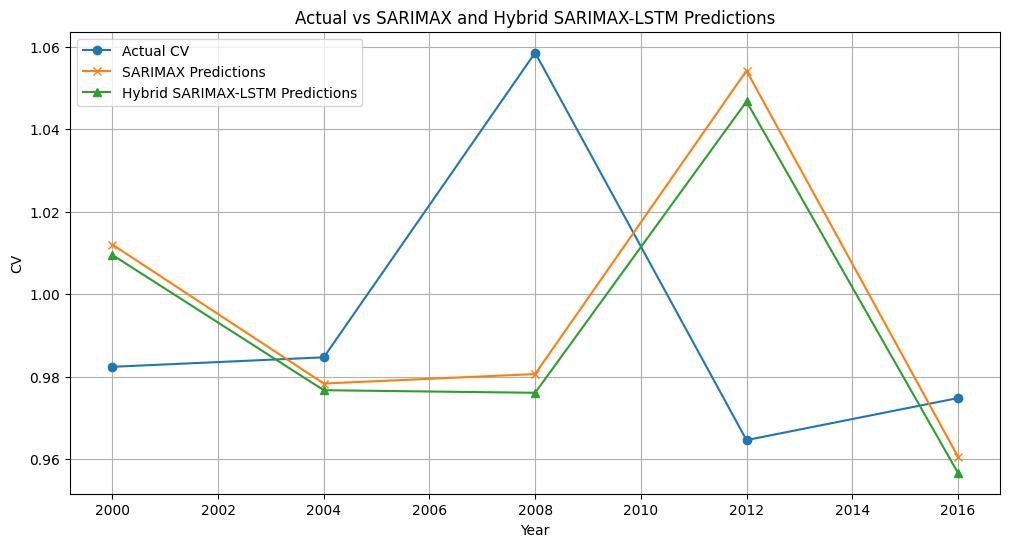

In [ ]:
# Prepare data with the best window size
X, y, X_train, y_train, X_test, y_test = prepare_data(window_size, return_X_y=True)


# Build the best model
model_lstm = tuner.hypermodel.build(best_hps)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with the best hyperparameters
history = model_lstm.fit(
    X_train, y_train,
    epochs=100,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1
)

# Make predictions on the test set residuals
y_pred_residual_scaled = model_lstm.predict(X_test)

# Inverse transform the scaled residual predictions
y_pred_residual = scaler.inverse_transform(y_pred_residual_scaled)

# Get SARIMAX predictions for the test set
split_ratio = 0.8
split_index = int(len(X) * split_ratio)
test_start_index = window_size + split_index
test_end_index = window_size + len(X)

test_indices = df.index[test_start_index : test_end_index]

sarimax_pred_test = df.loc[test_indices, 'CV_sarimax_pred'].values


test_indices = df.index[test_start_index : test_end_index]

sarimax_pred_test = df.loc[test_indices, 'CV_sarimax_pred'].values


# Combine SARIMAX predictions with LSTM residual predictions
# Combine SARIMAX predictions with LSTM residual predictions
final_pred = sarimax_pred_test + y_pred_residual.flatten()

# Actual CV values for test set
y_actual = df.loc[test_indices, 'CV'].values

# Evaluate
mse = mean_squared_error(y_actual, final_pred)
r2 = r2_score(y_actual, final_pred)

print(f"Hybrid Model Test MSE: {mse}")
print(f"Hybrid Model Test R²: {r2}")

# Plot actual vs SARIMAX and hybrid predictions
test_years = df.loc[test_indices, 'Year'].values

plt.figure(figsize=(12, 6))
plt.plot(test_years, y_actual, label='Actual CV', marker='o')
plt.plot(test_years, sarimax_pred_test, label='SARIMAX Predictions', marker='x')
plt.plot(test_years, final_pred, label='Hybrid SARIMAX-LSTM Predictions', marker='^')
plt.xlabel('Year')
plt.ylabel('CV')
plt.title('Actual vs SARIMAX and Hybrid SARIMAX-LSTM Predictions')
plt.legend()
plt.grid(True)
plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


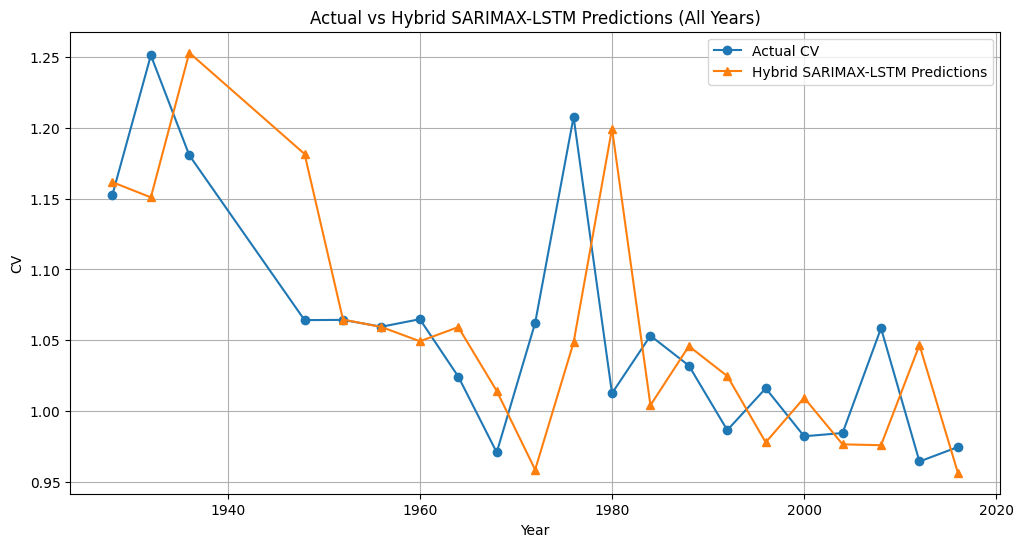

In [ ]:
# Predict SARIMAX values for all years in the DataFrame
sarimax_all_pred = sarimax2_model.predict(start=df.index[0], end=df.index[-1])

# Prepare residuals for LSTM predictions (all years)
df['CV_residual'] = df['CV'] - sarimax_all_pred
df['CV_residual'].fillna(method='bfill', inplace=True)
df['CV_residual_scaled'] = scaler.transform(df['CV_residual'].values.reshape(-1, 1))

# Create sequences for the entire dataset
data_all = df['CV_residual_scaled'].values
X_all, _ = create_sequences(data_all, window_size)

# Reshape input for LSTM
X_all = X_all.reshape((X_all.shape[0], window_size, 1))

# Predict LSTM residuals for all sequences
lstm_all_residual_scaled = model_lstm.predict(X_all)
lstm_all_residual = scaler.inverse_transform(lstm_all_residual_scaled)

# Combine SARIMAX predictions with LSTM residual predictions
hybrid_all_pred = sarimax_all_pred[window_size:] + lstm_all_residual.flatten()

# Actual values (aligned with hybrid predictions)
actual_values = df['CV'].values[window_size:]

# Plot actual vs hybrid predictions for all years
years = df['Year'].values[window_size:]

plt.figure(figsize=(12, 6))
plt.plot(years, actual_values, label='Actual CV', marker='o')
plt.plot(years, hybrid_all_pred, label='Hybrid SARIMAX-LSTM Predictions', marker='^')
plt.xlabel('Year')
plt.ylabel('CV')
plt.title('Actual vs Hybrid SARIMAX-LSTM Predictions (All Years)')
plt.legend()
plt.grid(True)
plt.show()

# Multivariated Time-series Training

In [ ]:
df_CV=data_dict['Athletics']['CV']
df_popularity = data_dict['Athletics']['popularity']
df_drug = data_dict['Athletics']['drug']
df_normalized_country = data_dict['Athletics']['normalized_country']

In [ ]:
df_total = pd.concat([df_CV,df_popularity,df_drug,df_normalized_country], axis=1)
df_total = df_total.loc[:, ~df_total.T.duplicated()]

In [ ]:
df_total.head()

,Year,CV,Year,popularity,Year,drug,normalized_country
0,1896.0,1.001050,1896,0.278947,1896.0,0.0,0.045
1,1900.0,0.975667,1900,0.120868,1976.0,1.0,0.085
2,1904.0,0.978102,1904,0.154497,1984.0,4.0,0.055
3,1906.0,0.892952,1906,0.271206,1988.0,1.0,0.100
4,1908.0,1.032252,1908,0.250887,1992.0,5.0,0.100


In [ ]:
# Print the list of column names
print("Column names:", df_total.columns.tolist())

# Check for duplicates
duplicates = df_total.columns.duplicated()
if duplicates.any():
    print("Duplicate columns found:")
    print(df_total.columns[duplicates])
else:
    print("No duplicate columns found.")


Column names: ['Year', 'CV', 'Year', 'popularity', 'Year', 'drug', 'normalized_country']
Duplicate columns found:
Index(['Year', 'Year'], dtype='object')


In [ ]:
df_total = df_total.loc[:, ~df_total.columns.duplicated()]

In [ ]:
df_total.head()

,Year,CV,popularity,drug,normalized_country
0,1896.0,1.001050,0.278947,0.0,0.045
1,1900.0,0.975667,0.120868,1.0,0.085
2,1904.0,0.978102,0.154497,4.0,0.055
3,1906.0,0.892952,0.271206,1.0,0.100
4,1908.0,1.032252,0.250887,5.0,0.100


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

In [ ]:
def adf_test(series, title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['Test Statistic', 'p-value', '# Lags Used', '# Observations Used']
    out = pd.Series(result[0:4], index=labels)
    for key, value in result[4].items():
        out[f'Critical Value ({key})'] = value
    print(out.to_string())
    print('---')

In [ ]:
# Apply ADF test on each column
for column in df_total.columns:
    adf_test(df_total[column], title=column)


Augmented Dickey-Fuller Test: Year
Test Statistic          -0.346653
p-value                  0.918632
# Lags Used              0.000000
# Observations Used     28.000000
Critical Value (1%)     -3.688926
Critical Value (5%)     -2.971989
Critical Value (10%)    -2.625296
---
Augmented Dickey-Fuller Test: CV
Test Statistic          -3.083080
p-value                  0.027831
# Lags Used              0.000000
# Observations Used     28.000000
Critical Value (1%)     -3.688926
Critical Value (5%)     -2.971989
Critical Value (10%)    -2.625296
---
Augmented Dickey-Fuller Test: popularity
Test Statistic          -4.070836
p-value                  0.001082
# Lags Used              0.000000
# Observations Used     30.000000
Critical Value (1%)     -3.669920
Critical Value (5%)     -2.964071
Critical Value (10%)    -2.621171
---
Augmented Dickey-Fuller Test: drug
Test Statistic          1.504062
p-value                 0.997539
# Lags Used             3.000000
# Observations Used     9.00000

In [ ]:
# Difference the non-stationary columns
df_total['drug_diff'] = df_total['drug'].diff()
df_total['normalized_country_diff'] = df_total['normalized_country'].diff()

# Drop the original non-stationary columns
df_total.drop(['drug', 'normalized_country'], axis=1, inplace=True)

# Drop the first row with NaN values resulting from differencing
df_total = df_total.dropna()


In [ ]:
# Re-apply ADF test on differenced columns
adf_test(df_total['drug_diff'], title='drug_diff')
adf_test(df_total['normalized_country_diff'], title='normalized_country_diff')


Augmented Dickey-Fuller Test: drug_diff
Test Statistic         -3.251875
p-value                 0.017172
# Lags Used             2.000000
# Observations Used     9.000000
Critical Value (1%)    -4.473135
Critical Value (5%)    -3.289881
Critical Value (10%)   -2.772382
---
Augmented Dickey-Fuller Test: normalized_country_diff
Test Statistic         -3.519119
p-value                 0.007509
# Lags Used             2.000000
# Observations Used     9.000000
Critical Value (1%)    -4.473135
Critical Value (5%)    -3.289881
Critical Value (10%)   -2.772382
---


In [ ]:
# Prepare the dataset with stationary variables
df_stationary = df_total[['CV', 'popularity', 'drug_diff', 'normalized_country_diff']]


In [ ]:
# Since the dataset is small, we may skip the train-test split or use cross-validation
data = df_stationary.copy()


In [ ]:
from statsmodels.tsa.api import VAR

# Fit the VAR model on the entire dataset
model = VAR(data)

# Limit maxlags to a small number due to limited data
maxlags = 1

# Select the optimal lag order
lag_order_results = model.select_order(maxlags=maxlags)
print(lag_order_results.summary())

# Choose the lag order with the lowest AIC
optimal_lag = lag_order_results.aic
if optimal_lag is None:
    optimal_lag = 1  # Default to 1 if AIC is not available


 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -10.54     -10.39*   2.655e-05      -10.63
1     -10.97*      -10.25  2.291e-05*     -11.43*
-------------------------------------------------


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [ ]:
# Fit the model with the optimal lag order
var_model = model.fit(optimal_lag)
print(var_model.summary())


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 18, Nov, 2024
Time:                     17:58:34
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -10.2473
Nobs:                     11.0000    HQIC:                  -11.4268
Log likelihood:           17.9059    FPE:                2.29128e-05
AIC:                     -10.9708    Det(Omega_mle):     5.11881e-06
--------------------------------------------------------------------
Results for equation CV
                                coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------------
const                              0.371640         0.383003            0.970           0.332
L1.CV                              0.555584         0.304085            1.827           0.068
L1.populari

In [ ]:
# Forecasting the next time point
forecast_steps = 1  # Adjust as needed
forecast = var_model.forecast(y=data.values[-optimal_lag:], steps=forecast_steps)

# Convert forecast to DataFrame
forecast_df = pd.DataFrame(forecast, index=[data.index[-1] + 1], columns=data.columns)
print(forecast_df)


          CV  popularity  drug_diff  normalized_country_diff
13  1.048828    0.171117  -0.188656                 0.020111


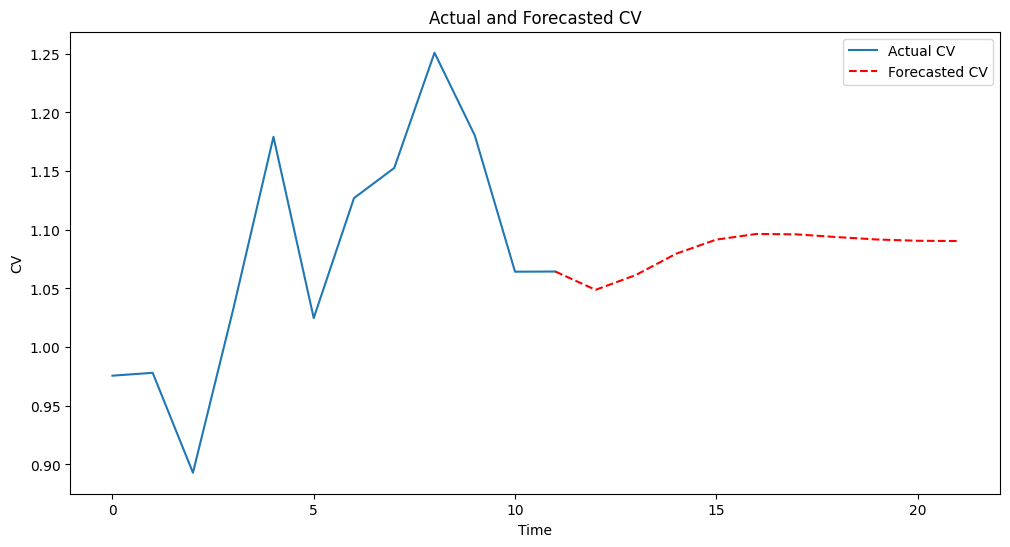

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Prepare Input Data for Forecasting
# Get the last 'optimal_lag' observations to use as input for forecasting
last_observations = df_stationary.values[-optimal_lag:]

# 2. Forecast Future Values
forecast_steps = 10  # Number of future time points to forecast
forecast = var_model.forecast(y=last_observations, steps=forecast_steps)

# 3. Convert Forecast to DataFrame
# Create an index for the forecasted periods
# Assuming your index is numeric and increments by 1
last_index = df_stationary.index[-1]
forecast_index = [last_index + i for i in range(1, forecast_steps + 1)]

# Create the forecast DataFrame
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=df_stationary.columns)

# 4. Invert Differencing (If Applicable)
# Identify differenced and non-differenced variables
differenced_vars = ['drug_diff', 'normalized_country_diff']
non_differenced_vars = ['CV', 'popularity']

# Invert differencing for differenced variables
# Get the last actual values of the original (non-differenced) data
last_actual_values = df_total.iloc[-1]

# Create a copy of the forecast DataFrame to store inverted values
forecast_df_inverted = forecast_df.copy()

# Invert differenced variables
for var in differenced_vars:
    # Cumulatively sum the forecasted differences and add to the last actual value
    forecast_df_inverted[var] = last_actual_values[var] + forecast_df[var].cumsum()

# Non-differenced variables remain the same
for var in non_differenced_vars:
    forecast_df_inverted[var] = forecast_df[var]

# 5. Combine Actual Data and Forecasts
# Reset index for proper concatenation
df_total_reset = df_total.reset_index(drop=True)
forecast_df_inverted_reset = forecast_df_inverted.reset_index(drop=True)

# Concatenate the actual data with the forecasted data
df_combined = pd.concat([df_total_reset, forecast_df_inverted_reset], ignore_index=True)

# 6. Plot the Results
plt.figure(figsize=(12,6))
plt.plot(df_combined.index[:len(df_total)], df_combined['CV'].iloc[:len(df_total)], label='Actual CV')
plt.plot(df_combined.index[len(df_total)-1:], df_combined['CV'].iloc[len(df_total)-1:], label='Forecasted CV', linestyle='--', color='red')
plt.legend()
plt.xlabel('Time')
plt.ylabel('CV')
plt.title('Actual and Forecasted CV')
plt.show()


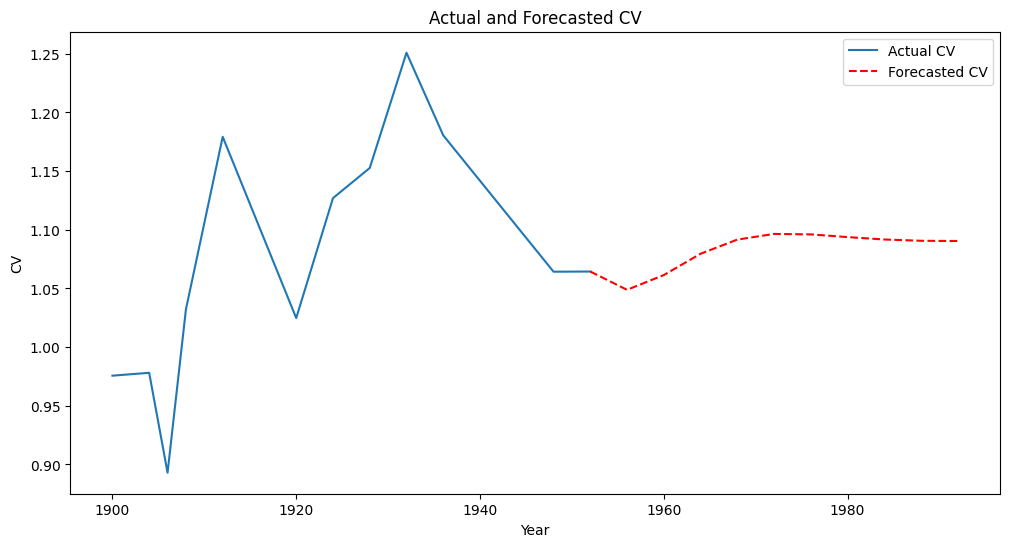

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Ensure 'Year' is Included and Set as Index
# Reset the index to ensure 'Year' is a column
df_total_reset = df_total.reset_index()

# Set 'Year' as the index
df_total_reset.set_index('Year', inplace=True)

# Now df_total_reset has 'Year' as the index

# Prepare df_stationary similarly if 'Year' is needed
df_stationary_reset = df_stationary.copy()
df_stationary_reset['Year'] = df_total_reset.index
df_stationary_reset.set_index('Year', inplace=True)

# 2. Prepare Input Data for Forecasting
# Get the last 'optimal_lag' observations to use as input for forecasting
last_observations = df_stationary_reset.values[-optimal_lag:]

# 3. Forecast Future Values
forecast_steps = 10  # Number of future time points to forecast

# Forecast future values
forecast = var_model.forecast(y=last_observations, steps=forecast_steps)

# 4. Generate Future 'Year's
# Assuming data is every 4 years
last_year = df_total_reset.index[-1]
future_years = [last_year + 4 * (i + 1) for i in range(forecast_steps)]

# Create forecast DataFrame with future 'Year's as index
forecast_df = pd.DataFrame(forecast, index=future_years, columns=df_stationary_reset.columns)

# 5. Invert Differencing (If Applicable)
# Identify differenced and non-differenced variables
differenced_vars = ['drug_diff', 'normalized_country_diff']
non_differenced_vars = ['CV', 'popularity']

# Get the last actual values from the original data
last_actual_values = df_total_reset.iloc[-1]

# Create a copy of the forecast DataFrame for inverted values
forecast_df_inverted = forecast_df.copy()

# Invert differenced variables
for var in differenced_vars:
    # Cumulatively sum the forecasted differences and add to the last actual value
    forecast_df_inverted[var] = last_actual_values[var] + forecast_df[var].cumsum()

# Non-differenced variables remain the same
for var in non_differenced_vars:
    forecast_df_inverted[var] = forecast_df[var]

# 6. Combine Actual Data and Forecasts
# Concatenate the actual data with the forecasted data
df_combined = pd.concat([df_total_reset, forecast_df_inverted], axis=0)

# 7. Plot the Results
plt.figure(figsize=(12,6))
plt.plot(df_combined.index[:len(df_total_reset)], df_combined['CV'].iloc[:len(df_total_reset)], label='Actual CV')
plt.plot(df_combined.index[len(df_total_reset)-1:], df_combined['CV'].iloc[len(df_total_reset)-1:], label='Forecasted CV', linestyle='--', color='red')
plt.legend()
plt.xlabel('Year')
plt.ylabel('CV')
plt.title('Actual and Forecasted CV')
plt.show()


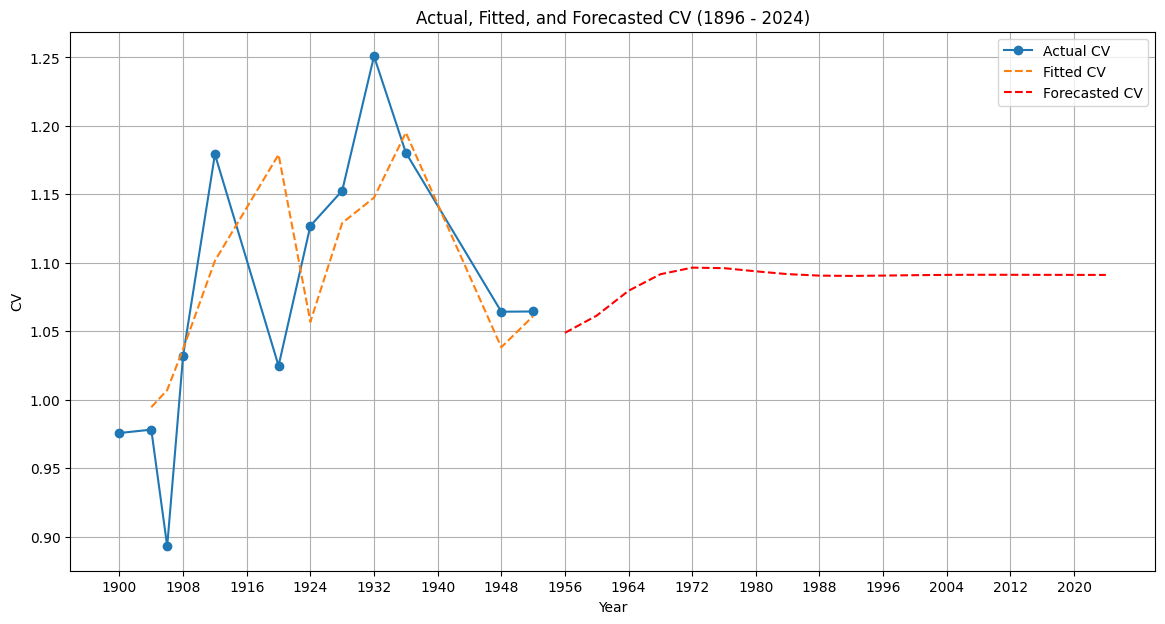

In [ ]:

# 1. Ensure 'Year' is included and set as index
df_total_reset = df_total.reset_index()
df_total_reset = df_total_reset.sort_values('Year')
df_total_reset.set_index('Year', inplace=True)

# Convert 'Year' index to integer type
df_total_reset.index = df_total_reset.index.astype(int)

# Prepare df_stationary similarly
df_stationary_reset = df_stationary.copy()
df_stationary_reset['Year'] = df_total_reset.index
df_stationary_reset.set_index('Year', inplace=True)

# 2. Get in-sample fitted values from the VAR model
fitted_values = var_model.fittedvalues
fitted_values.index = df_stationary_reset.index[optimal_lag:]
df_fitted = pd.DataFrame(fitted_values, index=fitted_values.index, columns=df_stationary_reset.columns)

# 3. Forecast future values up to 2024
last_year_in_data = df_total_reset.index[-1]
years_to_forecast = list(range(last_year_in_data + 4, 2025, 4))
forecast_steps = len(years_to_forecast)

# Prepare input data for forecasting
last_observations = df_stationary_reset.values[-optimal_lag:]

# Forecast future values
forecast = var_model.forecast(y=last_observations, steps=forecast_steps)

# Create forecast DataFrame with future 'Year's as index
forecast_df = pd.DataFrame(forecast, index=years_to_forecast, columns=df_stationary_reset.columns)

# 4. Invert differencing (if applicable)
differenced_vars = ['drug_diff', 'normalized_country_diff']  # Adjust based on your data
non_differenced_vars = ['CV', 'popularity']

# Get the last actual values from the original data
last_actual_values = df_total_reset.iloc[-1]

# Invert differenced variables for forecasted data
forecast_df_inverted = forecast_df.copy()
for var in differenced_vars:
    last_value = last_actual_values[var]
    forecast_df_inverted[var] = forecast_df[var].cumsum() + last_value

# Non-differenced variables remain the same
for var in non_differenced_vars:
    forecast_df_inverted[var] = forecast_df[var]

# Invert differencing for fitted values (in-sample predictions)
fitted_values_inverted = df_fitted.copy()
for var in differenced_vars:
    actual_values = df_total_reset[var].loc[fitted_values_inverted.index]
    fitted_values_inverted[var] = actual_values.shift(1) + fitted_values_inverted[var]

# Non-differenced variables remain the same
for var in non_differenced_vars:
    fitted_values_inverted[var] = df_fitted[var]

# 5. Combine actual data, fitted values, and forecasts
df_combined = pd.concat([
    df_total_reset[[*non_differenced_vars, *differenced_vars]].iloc[:optimal_lag],
    fitted_values_inverted,
    forecast_df_inverted
], axis=0)

# 6. Plot the results
plt.figure(figsize=(14,7))
plt.plot(df_total_reset.index, df_total_reset['CV'], label='Actual CV', marker='o')
plt.plot(fitted_values_inverted.index, fitted_values_inverted['CV'], label='Fitted CV', linestyle='--')
plt.plot(forecast_df_inverted.index, forecast_df_inverted['CV'], label='Forecasted CV', linestyle='--', color='red')
plt.legend()
plt.xlabel('Year')
plt.ylabel('CV')
plt.title('Actual, Fitted, and Forecasted CV (1896 - 2024)')
plt.xticks(range(df_total_reset.index[0], 2025, 8))  # Adjust ticks as needed
plt.grid(True)
plt.show()


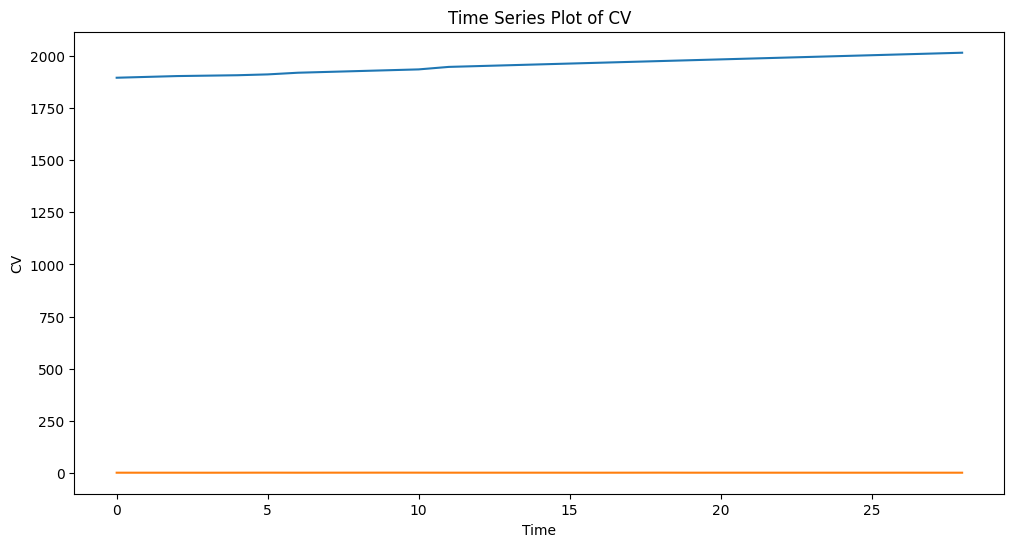

ValueError: x is required to have ndim 1 but has ndim 2

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Load your time series data into a pandas Series
# Assuming 'cv_series' is your target variable (e.g., 'CV')
cv_series=df_CV
# Step 1: Visualize the Data
plt.figure(figsize=(12,6))
plt.plot(cv_series)
plt.title('Time Series Plot of CV')
plt.xlabel('Time')
plt.ylabel('CV')
plt.show()

# Step 2: Check for Stationarity using the Augmented Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(cv_series)
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

# If the p-value > 0.05, the series is non-stationary and needs differencing
if adf_result[1] > 0.05:
    cv_series_diff = cv_series.diff().dropna()
    d = 1  # Order of differencing
else:
    cv_series_diff = cv_series
    d = 0

# Step 3: Plot ACF and PACF to determine p and q
fig, axes = plt.subplots(1, 2, figsize=(16,4))
plot_acf(cv_series_diff, ax=axes[0], lags=20)
plot_pacf(cv_series_diff, ax=axes[1], lags=20)
plt.show()

# Based on the plots, choose appropriate p and q
# For example, let's assume p=1 and q=1
p = 1
q = 1

# Step 4: Fit the ARIMA model
model = ARIMA(cv_series, order=(p, d, q))
model_fit = model.fit()
print(model_fit.summary())

# Step 5: Forecast future values
forecast_steps = 10  # Number of periods to forecast
forecast = model_fit.forecast(steps=forecast_steps)

# Step 6: Create a time index for the forecasted values
# Assuming your original data has a DatetimeIndex or PeriodIndex
last_date = cv_series.index[-1]
forecast_index = pd.date_range(start=last_date, periods=forecast_steps + 1, freq='4Y')[1:]

# Step 7: Plot the actual and forecasted values
plt.figure(figsize=(12,6))
plt.plot(cv_series, label='Actual CV')
plt.plot(forecast_index, forecast, label='Forecasted CV', linestyle='--', color='red')
plt.legend()
plt.xlabel('Time')
plt.ylabel('CV')
plt.title('Actual and Forecasted CV using ARIMA')
plt.show()


In [ ]:
# Install ManimCE (Manim Community Edition)
!sudo apt update
!sudo apt install libcairo2-dev ffmpeg texlive texlive-latex-extra texlive-fonts-extra texlive-latex-recommended dvipng cm-super
!pip install manimce


Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,113 kB]
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,482 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-sec

In [ ]:
!pip uninstall manimce
!pip install manim

Found existing installation: manimce 0.1.1.post2
Uninstalling manimce-0.1.1.post2:
  Would remove:
    /usr/local/bin/manim
    /usr/local/bin/manimce
    /usr/local/lib/python3.10/dist-packages/manim/*
    /usr/local/lib/python3.10/dist-packages/manimce-0.1.1.post2.dist-info/*
Proceed (Y/n)? Y
  Successfully uninstalled manimce-0.1.1.post2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 42.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [ ]:
!pip install manim

  Using cached manim-0.18.1-py3-none-any.whl.metadata (10 kB)
  Using cached cloup-3.0.5-py2.py3-none-any.whl.metadata (6.7 kB)
  Using cached isosurfaces-0.1.2-py3-none-any.whl.metadata (3.3 kB)
  Using cached manimpango-0.6.0.tar.gz (4.1 MB)
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [ ]:
# Importing Manim classes
from manim import *

# Create a scene for animation
class CircleToSquare(Scene):
    def construct(self):
        circle = Circle()  # Create a circle
        square = Square()  # Create a square
        self.play(Create(circle))  # Animate creation of the circle
        self.wait(1)
        self.play(Transform(circle, square))  # Transform circle into square
        self.wait(1)


ModuleNotFoundError: No module named 'manim'